In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

from functions_file import *
print(testfunction(4))

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn as sn
import itertools
import collections        
from matplotlib import colors

from NNet import *
from scipy.stats import linregress
import copy
import time
from random import randrange

16


## Model-based Approach

### 1. Load Data

All columns:

    ['polygon','DOW','times','exp_id','lanes','direction',
    'busstops','seplane','complexity','length','road_rank',
    'v_Bus', 'k_Bus', 'q_Bus', # Taxi, Motorcycle, Heavy Vehicle, Medium Vehicle, Car
    'v_Car0020','k_Car0020', 'q_Car0020'] # e.g. 0020 = 2%

In [10]:
# speed_threshold = 1 #km/h
min_mean_speed = 15 #km/h
# min_diff_between_timestamps = '3s' #has to be a string
min_duration_of_stops = 5 #seconds
# Select desired data
cols = ['exp_id','times','polygon','DOW','lanes','busstops','seplane','length','road_rank','stop_count','lane_changes']
complexity = 1 # only use links with this level of complexity (exclude link 4)
modes_MS = ['Bus','Taxi','Car0050','Car','all','Motorcycle','Medium Vehicle']
modes_LD = ['all']
scalefactorsfile = '../output/data_processed/scalefactors_bypolygon.pkl'
datafile = '../output/data_processed_events_%skmh_%ssec/processed_data_all_bypolygon.pkl'%(min_mean_speed,min_duration_of_stops)

In [11]:
[cols.extend(['v_%s_MS'%(m),'q_%s_MS'%(m),'k_%s_MS'%(m)]) for m in modes_MS ]
[cols.extend(['v_%s_LD'%(m),'q_%s_LD'%(m),'k_%s_LD'%(m)]) for m in modes_LD ]
all_data = pd.read_pickle(datafile)
print(sorted(all_data.columns))
data = all_data[(all_data.complexity==complexity)][cols].reset_index(drop=True)

with open(scalefactorsfile, 'rb') as f:
    scalefactors = pickle.load(f)

data = data[~(data.polygon.isin(['polygon_r12','polygon_r13','polygon_r14','polygon_r15','polygon_r16',\
                      'polygon_r17','polygon_r18','polygon_r19','polygon_r20']))].reset_index(drop=True)

scale_stop_lc = [[0,1],[0,1]]

display(data.iloc[:3,:])

['DOW', 'busstops', 'complexity', 'density_induced', 'diff_1_all_MS', 'diff_2_all_MS', 'diff_3_all_MS', 'diff_to_threshold_quantile', 'direction', 'exp_id', 'k_Bus_MS', 'k_Car0050_MS', 'k_Car_MS', 'k_Heavy Vehicle_MS', 'k_Medium Vehicle_MS', 'k_Motorcycle_MS', 'k_Taxi_MS', 'k_all_LD', 'k_all_LD_s', 'k_all_MS', 'k_all_MS_s', 'lane_changes', 'lanes', 'length', 'polygon', 'q_Bus_MS', 'q_Car0050_MS', 'q_Car_MS', 'q_Heavy Vehicle_MS', 'q_Medium Vehicle_MS', 'q_Motorcycle_MS', 'q_Taxi_MS', 'q_all_LD', 'q_all_LD_s', 'q_all_MS', 'q_all_MS_s', 'road_rank', 'seplane', 'stop_count', 'threshold', 'times', 'v2', 'v_Bus_MS', 'v_Car0050_MS', 'v_Car_MS', 'v_Heavy Vehicle_MS', 'v_Medium Vehicle_MS', 'v_Motorcycle_MS', 'v_Taxi_MS', 'v_all_LD', 'v_all_MS', 'veh_stop_lengths', 'veh_stop_types']


exp_id               times     polygon  DOW  lanes  busstops  seplane  \
0     1.0 2018-10-24 08:31:00  polygon_r0  Wed      3         0        1   
1     1.0 2018-10-24 08:31:30  polygon_r0  Wed      3         0        1   
2     1.0 2018-10-24 08:32:00  polygon_r0  Wed      3         0        1   

   length  road_rank  stop_count  ...  k_all_MS  v_Motorcycle_MS  \
0   0.105          0         0.0  ...  1.554321        48.221745   
1   0.105          0         0.0  ...  1.479669        52.135825   
2   0.105          0         0.0  ...  1.044013        34.757217   

   q_Motorcycle_MS  k_Motorcycle_MS  v_Medium Vehicle_MS  q_Medium Vehicle_MS  \
0         0.821110         0.700837            46.890349             0.257684   
1         0.698574         0.561916            23.445175             0.128842   
2         0.465716         0.374610            32.578725             0.174600   

   k_Medium Vehicle_MS   v_all_LD  q_all_LD  k_all_LD  
0             0.226184  41.994024  2.037116  1.282766  
1             0.113092  46.472627  3.346691  1.849675  
2             0.147199  46.237944  2.570646  1.429280  

[3 rows x 35 columns]

## Multi-output NN with physical FD contraint (batched)

- CalcV --> calculate estimated derived speed and its error?
- Sensor scenarios --> can be found at the end of functions_file.py --> e.g. 'Scen1_qk'
- Input_sensor_cols --> e.g. ['q_all_LD','k_all_LD']

In [12]:
data['polygon'].index

RangeIndex(start=0, stop=4675, step=1)

##################################################################
0 Scen0_qk 0.6
##################################################################


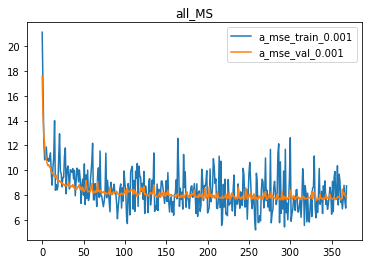

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [224.45695    16.615673    1.4222355   4.1025414]
Loss MAPE
 [0.180936, 0.2008187, 0.5825882, 0.44077176]
Loss RMSE
 [401.89413    28.773062    2.3997548   5.806705 ]
Loss R2
 [0.8064934199399385, 0.7544723496612444, 0.6016572238018959, 0.5208120702503445]
Loss MAE
 [224.45695, 16.615683, 1.422236, 4.1025386]
Loss MAPE
 [5507544000000000.0, 0.2008187, 2071536100000000.0, 781043760000000.0]
Loss RMSE
 [401.89407030957796, 28.77305885747334, 2.399754563338492, 5.806706320053866]
Loss R2
 [0.7889844515074282, 0.7515031731090903, 0.5851274607026946, 0.5165273716144456]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
0 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

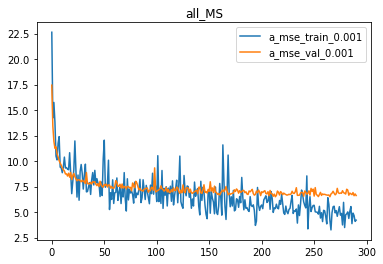

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [215.77673    13.84257     1.0481254   3.9133844]
Loss MAPE
 [0.15364699, 0.16114731, 0.47195745, 0.44031927]
Loss RMSE
 [331.46155    21.18321     1.7361125   5.1648026]
Loss R2
 [0.8649074104829119, 0.8769927538073203, 0.717860111569723, 0.620456211627168]
Loss MAE
 [215.77682, 13.842559, 1.0481248, 3.9133816]
Loss MAPE
 [6618483400000000.0, 217203060000000.0, 1622000800000000.0, 168073500000000.0]
Loss RMSE
 [331.46159515470265, 21.183218104151383, 1.7361125318733335, 5.164801517302942]
Loss R2
 [0.859425052615266, 0.87693038992801, 0.7094076093938941, 0.5973358352312879]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
0 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

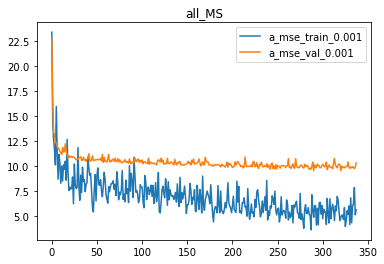

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [214.05324    15.646999    1.1954962   3.974839 ]
Loss MAPE
 [0.13494547, 0.15819392, 0.5198384, 0.42262948]
Loss RMSE
 [330.50223    25.282827    1.8485341   5.4428587]
Loss R2
 [0.8557427071441388, 0.8220833425210624, 0.734831164165833, 0.5663912322195477]
Loss MAE
 [214.05328, 15.646999, 1.1954964, 3.9748397]
Loss MAPE
 [7358197000000000.0, 342525700000000.0, 1985720400000000.0, 284138260000000.0]
Loss RMSE
 [330.50218654723, 25.28282645347554, 1.8485342121378803, 5.442859507625654]
Loss R2
 [0.8509619323292351, 0.8220803639766413, 0.7215506854901261, 0.5638626177404162]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
0 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


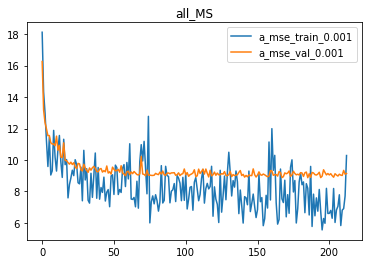

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [248.76222    17.061003    1.2642065   3.9920216]
Loss MAPE
 [0.19829403, 0.20453683, 0.611848, 0.4062258]
Loss RMSE
 [407.69147    27.006664    2.2500365   5.4670444]
Loss R2
 [0.7972418822959702, 0.798004604120323, 0.6254955615012427, 0.5951340345385401]
Loss MAE
 [248.76224, 17.060995, 1.2642062, 3.9920194]
Loss MAPE
 [1.8424385e+16, 565198800000000.0, 1222477600000000.0, 294478660000000.0]
Loss RMSE
 [407.6915768997442, 27.00666896262905, 2.2500375108770974, 5.467044586206368]
Loss R2
 [0.7904124274684134, 0.783945409468003, 0.6224543270593732, 0.5862955014697318]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
0 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


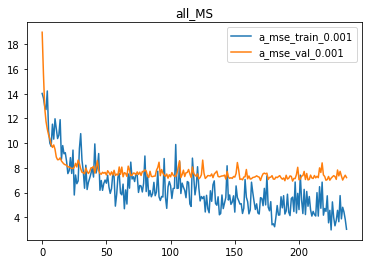

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [230.40282    14.161496    0.9415114   3.8143983]
Loss MAPE
 [0.2040063, 0.16916718, 0.4280051, 0.453969]
Loss RMSE
 [366.93524    20.538067    1.4651899   5.3075852]
Loss R2
 [0.8433779577349849, 0.8654949097622124, 0.8359548395972078, 0.592961868187662]
Loss MAE
 [230.4027, 14.1615, 0.9415111, 3.8143988]
Loss MAPE
 [0.2040063, 0.16916718, 1407443500000000.0, 529250700000000.0]
Loss RMSE
 [366.93513135839146, 20.538069940832592, 1.4651900632295862, 5.307585294148657]
Loss R2
 [0.8247721785100827, 0.8641524560002444, 0.8312693228961685, 0.58080137968059]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


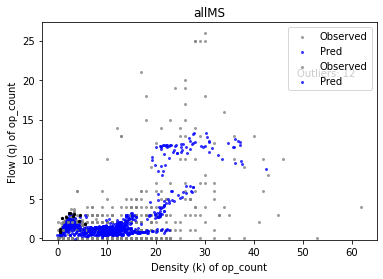

##################################################################
1 Scen0_qk 0.6
##################################################################


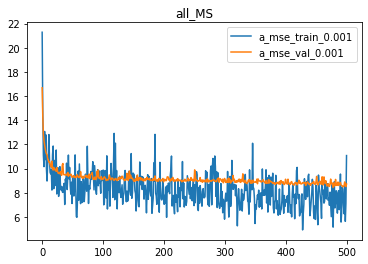

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [241.25882    17.781906    1.3448209   3.907858 ]
Loss MAPE
 [0.20596412, 0.21128242, 0.59462786, 0.40826577]
Loss RMSE
 [405.02966    27.35905     2.3276873   5.4213443]
Loss R2
 [0.8164104954560579, 0.7960782905218092, 0.6068318841987135, 0.5950105978785938]
Loss MAE
 [241.25894, 17.781906, 1.3448206, 3.9078584]
Loss MAPE
 [2.3158526e+16, 667755340000000.0, 1727277200000000.0, 331221940000000.0]
Loss RMSE
 [405.0296671232862, 27.359047060427518, 2.3276873695683444, 5.42134500601044]
Loss R2
 [0.793140386652972, 0.7782705463000493, 0.5959460993955517, 0.5931830341030282]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
1 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


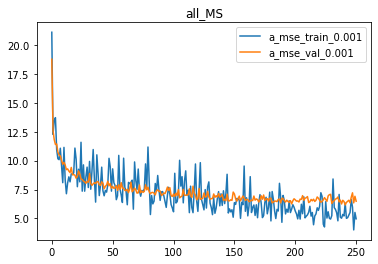

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 13
Loss MAE
 [219.02858    14.308909    1.1431074   3.8623273]
Loss MAPE
 [0.13733639, 0.14908743, 0.49195346, 0.43580127]
Loss RMSE
 [385.58405    21.237566    1.9334654   5.4979696]
Loss R2
 [0.8117368243581833, 0.8728961578934692, 0.7461200815930281, 0.5266718772312728]
Loss MAE
 [219.02876, 14.308908, 1.1431069, 3.8623257]
Loss MAPE
 [2.4237926e+16, 889351500000000.0, 1759395000000000.0, 280535440000000.0]
Loss RMSE
 [385.5838308656109, 21.23757248047152, 1.9334655102676466, 5.497969165747455]
Loss R2
 [0.8002933092986069, 0.8660022489786404, 0.7438247412584185, 0.5031377153335244]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
1 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


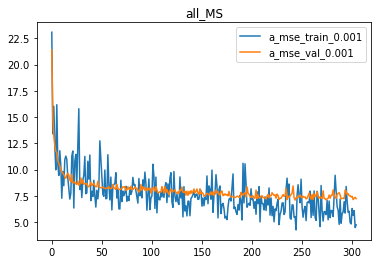

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [254.55347    15.977602    1.2604889   3.9184844]
Loss MAPE
 [0.14034031, 0.1613875, 0.5168988, 0.4379095]
Loss RMSE
 [423.62823    25.39065     2.4146013   5.3835   ]
Loss R2
 [0.7781537186194283, 0.809601840228624, 0.603005739240982, 0.5314605088791304]
Loss MAE
 [254.55351, 15.977606, 1.2604893, 3.9184864]
Loss MAPE
 [3.485142e+16, 973084630000000.0, 1754453200000000.0, 437673300000000.0]
Loss RMSE
 [423.62820889902974, 25.39065264421572, 2.414601484948546, 5.383502533953249]
Loss R2
 [0.7589402399158155, 0.8084705834739259, 0.60046460742603, 0.5236115401203731]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
1 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


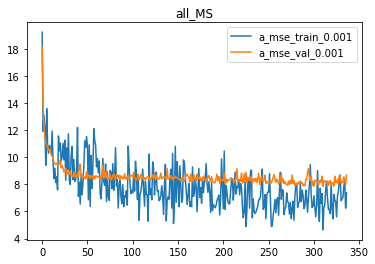

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [211.33032    15.974688    1.2006806   3.9012284]
Loss MAPE
 [0.17464688, 0.18369934, 0.56112885, 0.47988978]
Loss RMSE
 [359.1386     25.396347    2.0668652   5.410443 ]
Loss R2
 [0.8368355156028541, 0.7951328966186981, 0.6677325798621976, 0.5750450863728157]
Loss MAE
 [211.33044, 15.974685, 1.200681, 3.9012308]
Loss MAPE
 [0.17464688, 0.18369934, 1618828100000000.0, 509979400000000.0]
Loss RMSE
 [359.1385744040871, 25.396349114387363, 2.0668650588311848, 5.410443394060871]
Loss R2
 [0.8321394896355794, 0.7922815249013558, 0.6642388938454854, 0.5643963341986976]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
1 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


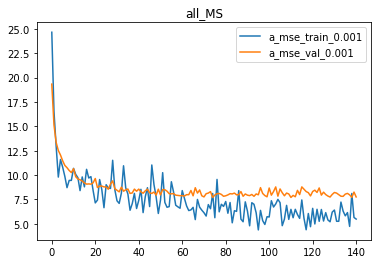

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [223.40211    15.133984    1.1026254   3.7386498]
Loss MAPE
 [0.17392837, 0.1641789, 0.49546006, 0.38015842]
Loss RMSE
 [372.31757    22.727743    1.8047726   5.214901 ]
Loss R2
 [0.8343198689468536, 0.8311461908887757, 0.7879679133731877, 0.5868787727898233]
Loss MAE
 [223.40216, 15.133984, 1.1026258, 3.738652]
Loss MAPE
 [1.0357649e+16, 350364070000000.0, 1401072000000000.0, 232252840000000.0]
Loss RMSE
 [372.31750982864077, 22.727741461341772, 1.804773303877942, 5.214902453145715]
Loss R2
 [0.8174759471270286, 0.8281851781784467, 0.7521488208491623, 0.5779632982840134]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

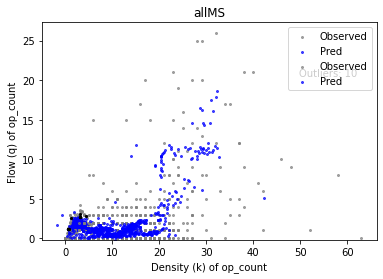

##################################################################
2 Scen0_qk 0.6
##################################################################


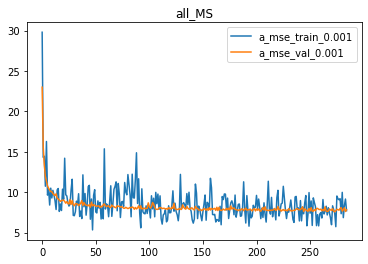

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 15
Loss MAE
 [252.66678    16.902925    1.5127821   4.144764 ]
Loss MAPE
 [0.20125134, 0.21037379, 0.579413, 0.4617485]
Loss RMSE
 [421.01248    29.274672    2.4251337   5.8463426]
Loss R2
 [0.8083426292356986, 0.7501229803738985, 0.6164552546494682, 0.5233164994315206]
Loss MAE
 [252.66687, 16.902927, 1.5127821, 4.1447606]
Loss MAPE
 [5947591000000000.0, 0.21037379, 2505194300000000.0, 782446800000000.0]
Loss RMSE
 [421.0124886805616, 29.27467492213833, 2.425133463539482, 5.846342603053245]
Loss R2
 [0.7684305687148245, 0.7427632732809735, 0.5763059809381352, 0.5099045473677631]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
2 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

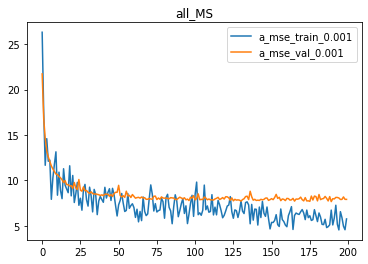

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [216.17358    15.3962145   1.1653396   4.0329895]
Loss MAPE
 [0.17616302, 0.17813803, 0.44139916, 0.4144382]
Loss RMSE
 [343.99155    23.203037    1.9338133   5.4406204]
Loss R2
 [0.8585529108332102, 0.8478092906018716, 0.7224652229769992, 0.5950002852393301]
Loss MAE
 [216.17348, 15.396214, 1.16534, 4.032988]
Loss MAPE
 [1.6005259e+16, 494968540000000.0, 1687138300000000.0, 310687200000000.0]
Loss RMSE
 [343.9914833611437, 23.203026357113554, 1.9338138339474291, 5.440622419765328]
Loss R2
 [0.8507901734899281, 0.8405183671278704, 0.7211187797564933, 0.5902847244751243]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
2 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


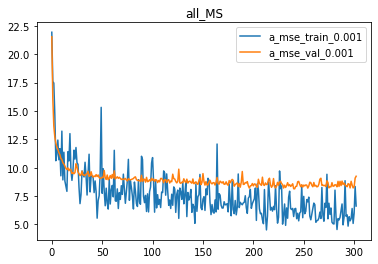

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [216.77058    17.26516     1.2674439   3.683668 ]
Loss MAPE
 [0.17592788, 0.19609709, 0.58957386, 0.3913719]
Loss RMSE
 [375.29904    25.607065    2.259512    5.0952487]
Loss R2
 [0.8222956243960858, 0.7849621660039531, 0.6346521909708586, 0.6159076164539318]
Loss MAE
 [216.77066, 17.265163, 1.2674438, 3.6836689]
Loss MAPE
 [1.1490608e+16, 408854280000000.0, 1485173700000000.0, 426030700000000.0]
Loss RMSE
 [375.29906824424705, 25.607051164394885, 2.2595119746094112, 5.095249446793437]
Loss R2
 [0.8145408906003455, 0.781894201121636, 0.6115144042741991, 0.5971079103714032]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
2 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

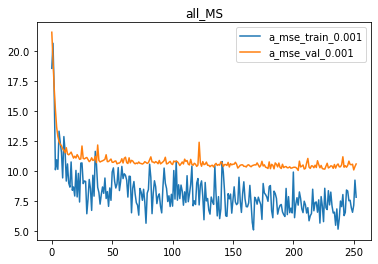

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [252.6631     15.623865    1.3252454   4.033174 ]
Loss MAPE
 [0.15164, 0.15432775, 0.5722149, 0.4291019]
Loss RMSE
 [372.69775    26.41159     2.135819    5.3912873]
Loss R2
 [0.8277158330650201, 0.8112215505720457, 0.6462218421779141, 0.5757252806197674]
Loss MAE
 [252.66304, 15.6238785, 1.325245, 4.0331736]
Loss MAPE
 [7614309000000000.0, 295023300000000.0, 2167935500000000.0, 284779280000000.0]
Loss RMSE
 [372.6977034071984, 26.411600327052078, 2.1358193242743178, 5.391287677225499]
Loss R2
 [0.8104769637905066, 0.8058389979311684, 0.6282763632117236, 0.5720883612756239]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
2 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


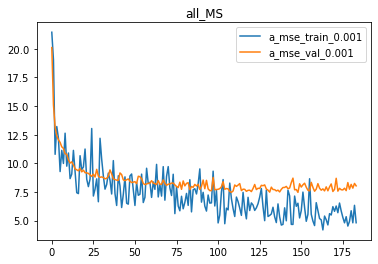

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 18
Loss MAE
 [200.9717     16.14951     1.0818524   3.7443035]
Loss MAPE
 [0.16815513, 0.16915403, 0.46215126, 0.3926374]
Loss RMSE
 [327.68414    25.352282    1.7018276   5.255494 ]
Loss R2
 [0.8633082656652558, 0.7990861181541536, 0.7832946821412876, 0.5896635786196174]
Loss MAE
 [200.97157, 16.149515, 1.0818516, 3.744306]
Loss MAPE
 [1.0209542e+16, 246132040000000.0, 1539457700000000.0, 266101510000000.0]
Loss RMSE
 [327.68410855578577, 25.352270309841707, 1.701827088409035, 5.25549482983021]
Loss R2
 [0.8586147953240173, 0.7862127555529949, 0.7796178135627916, 0.5713675406102721]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

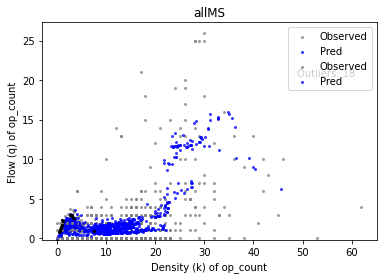

##################################################################
3 Scen0_qk 0.6
##################################################################


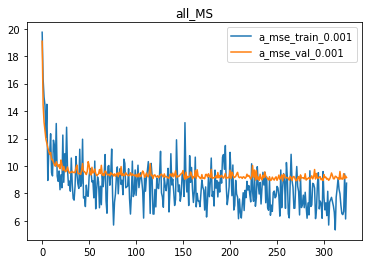

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 1
Loss MAE
 [247.25282    16.282736    1.2717313   3.7543352]
Loss MAPE
 [0.17549422, 0.1828949, 0.5351141, 0.41445604]
Loss RMSE
 [396.36786    27.034477    2.1550267   5.217627 ]
Loss R2
 [0.8133507150320352, 0.7603834636395213, 0.6497670577666429, 0.5864881652170733]
Loss MAE
 [247.25285, 16.282732, 1.2717309, 3.7543368]
Loss MAPE
 [1.078387e+16, 362712030000000.0, 1824516300000000.0, 309015800000000.0]
Loss RMSE
 [396.3678452523615, 27.034478672786996, 2.155026627838532, 5.217627124709086]
Loss R2
 [0.7931335546807721, 0.7569005036272376, 0.6466126932858135, 0.577522176214905]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
3 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

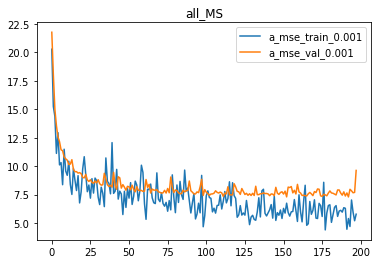

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [212.60612    14.26272     1.1196067   4.1270423]
Loss MAPE
 [0.13437334, 0.17095906, 0.5153671, 0.33989093]
Loss RMSE
 [314.53683    22.587826    2.0738873   5.7098837]
Loss R2
 [0.8811332752486015, 0.8467121699964356, 0.7301450577630253, 0.583780801858876]
Loss MAE
 [212.60612, 14.262716, 1.1196076, 4.1270413]
Loss MAPE
 [4682310000000000.0, 0.17095906, 1113898900000000.0, 347501070000000.0]
Loss RMSE
 [314.5367749763134, 22.587833120468307, 2.0738875704817703, 5.709883690499589]
Loss R2
 [0.8598437026747607, 0.8457795401416878, 0.6877876788407391, 0.5177321055996362]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
3 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

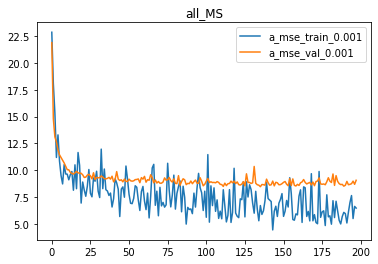

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [221.14925    16.813063    1.2281516   3.7066493]
Loss MAPE
 [0.17514938, 0.2030096, 0.53630793, 0.41663206]
Loss RMSE
 [375.93417    24.956856    2.0919235   5.0533657]
Loss R2
 [0.8241285704286604, 0.801903401160076, 0.6686339277901804, 0.621173398843066]
Loss MAE
 [221.14922, 16.813047, 1.2281516, 3.7066505]
Loss MAPE
 [1.1142645e+16, 373006370000000.0, 1663445100000000.0, 378162840000000.0]
Loss RMSE
 [375.9342736769288, 24.956852414154213, 2.091923158682234, 5.053365307474429]
Loss R2
 [0.81391256508682, 0.792829599444841, 0.6670054641707235, 0.6037044309823637]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
3 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

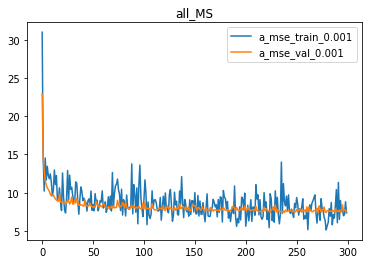

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [250.061      16.018656    1.3497782   3.923058 ]
Loss MAPE
 [0.18023118, 0.17802326, 0.5580306, 0.43855363]
Loss RMSE
 [408.77728    24.575258    2.2225866   5.0662923]
Loss R2
 [0.7901362093620687, 0.8112893622069673, 0.6147809295039778, 0.5920307916538056]
Loss MAE
 [250.06104, 16.018656, 1.3497778, 3.9230595]
Loss MAPE
 [1.7668566e+16, 415065340000000.0, 2266249400000000.0, 543876640000000.0]
Loss RMSE
 [408.7773500024188, 24.575261574300942, 2.2225856669235418, 5.0662931195807]
Loss R2
 [0.7746391424214352, 0.8086389005088662, 0.6037537809730411, 0.5904270940382452]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
3 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

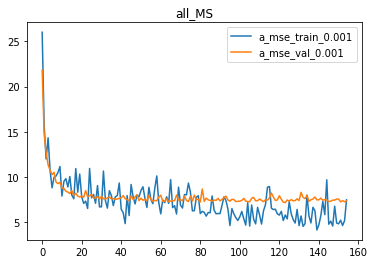

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [231.0414      14.857377     0.92022854   3.8524222 ]
Loss MAPE
 [0.1923443, 0.18733874, 0.45074207, 0.4550995]
Loss RMSE
 [363.66235    21.776766    1.5398126   5.3507586]
Loss R2
 [0.8339290449072302, 0.8485589333672682, 0.8185809887761701, 0.57923724300096]
Loss MAE
 [231.04143, 14.857376, 0.92022824, 3.8524237]
Loss MAPE
 [0.1923443, 0.18733874, 1081468130000000.0, 532122720000000.0]
Loss RMSE
 [363.66244650774706, 21.776764636358262, 1.5398119345929213, 5.350758914062649]
Loss R2
 [0.8278839537840276, 0.8472718030416917, 0.8136448083768653, 0.5739538945135005]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


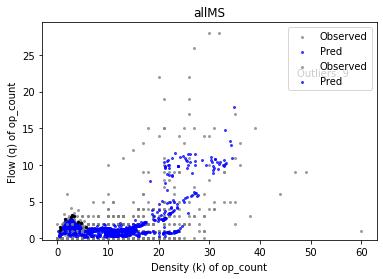

##################################################################
4 Scen0_qk 0.6
##################################################################


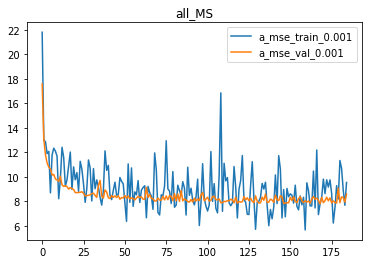

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [234.23521    18.954613    1.2051101   4.1586995]
Loss MAPE
 [0.17069155, 0.22115643, 0.6425805, 0.5064627]
Loss RMSE
 [404.7988     27.359776    2.1893032   5.401374 ]
Loss R2
 [0.7981809018591645, 0.8047269270050879, 0.617039396901007, 0.5673977871076068]
Loss MAE
 [234.2353, 18.95461, 1.2051103, 4.158696]
Loss MAPE
 [1.820391e+16, 515108180000000.0, 1426145900000000.0, 588237040000000.0]
Loss RMSE
 [404.7986575138312, 27.359769860799954, 2.1893030637552813, 5.401373455435027]
Loss R2
 [0.7790047419024041, 0.7628177486568307, 0.6155322773852359, 0.5344578339064203]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
4 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

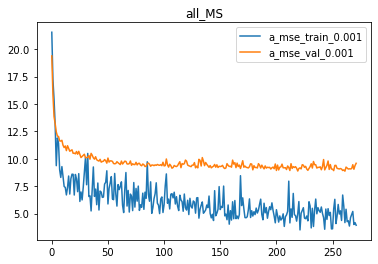

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [213.81963    14.572523    1.0692209   3.8729575]
Loss MAPE
 [0.13224995, 0.14364415, 0.49998194, 0.43199056]
Loss RMSE
 [309.19357    22.941303    1.8182539   5.1587496]
Loss R2
 [0.8761854120633459, 0.869671222494394, 0.7503829185584615, 0.625776832287177]
Loss MAE
 [213.81969, 14.572527, 1.0692208, 3.8729565]
Loss MAPE
 [6360781600000000.0, 183247350000000.0, 1505383600000000.0, 419792050000000.0]
Loss RMSE
 [309.1935326377316, 22.941306149215464, 1.8182537568555874, 5.158750170667723]
Loss R2
 [0.8695604137807469, 0.8535097046821678, 0.7305983974439242, 0.6082057737589599]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
4 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


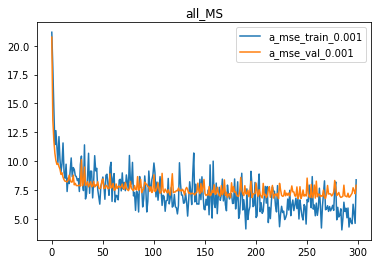

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [248.66212    15.836499    1.2580465   4.10618  ]
Loss MAPE
 [0.15081677, 0.16717175, 0.6034366, 0.459611]
Loss RMSE
 [416.19006    26.062002    2.5959895   5.905587 ]
Loss R2
 [0.7807901680317724, 0.801620627588136, 0.6374023063470188, 0.5995448763334003]
Loss MAE
 [248.66228, 15.8364935, 1.2580469, 4.10618]
Loss MAPE
 [1.5679524e+16, 490846040000000.0, 1228068300000000.0, 500037470000000.0]
Loss RMSE
 [416.19016086399733, 26.062003517453334, 2.59598931772065, 5.905586326489448]
Loss R2
 [0.7734203835585969, 0.7996950241115286, 0.62412596022828, 0.5760620725672387]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
4 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


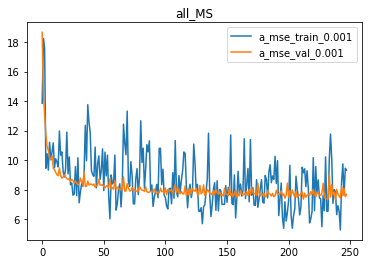

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [219.69064    15.883264    1.2342801   3.9927878]
Loss MAPE
 [0.15384084, 0.16674908, 0.60767496, 0.44210407]
Loss RMSE
 [360.95743    25.19905     2.1650546   5.183403 ]
Loss R2
 [0.8337469325750583, 0.8045859760791011, 0.6262454048875978, 0.5752409155962053]
Loss MAE
 [219.69057, 15.883271, 1.2342798, 3.9927871]
Loss MAPE
 [1.8656492e+16, 344487750000000.0, 1710604400000000.0, 503820370000000.0]
Loss RMSE
 [360.9574507473145, 25.199057376731005, 2.165055140262247, 5.183402407922902]
Loss R2
 [0.8242817745094695, 0.7988009237913127, 0.624001563903869, 0.5712733616003776]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
4 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

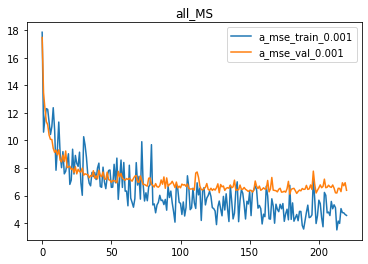

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [224.68062    13.743551    1.1190732   3.8372111]
Loss MAPE
 [0.12811992, 0.13776658, 0.42550611, 0.4562041]
Loss RMSE
 [345.9541     20.724382    1.7036817   5.4633627]
Loss R2
 [0.8502701207601988, 0.8753840816696276, 0.8072194191568317, 0.5426213413573793]
Loss MAE
 [224.68074, 13.743559, 1.119073, 3.837209]
Loss MAPE
 [3.3622207e+16, 642315800000000.0, 1930633600000000.0, 603763550000000.0]
Loss RMSE
 [345.9541041633991, 20.724388402512705, 1.7036819947091268, 5.463361952316676]
Loss R2
 [0.8392348369365539, 0.8723998441949523, 0.8010969717069018, 0.5093731229271652]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


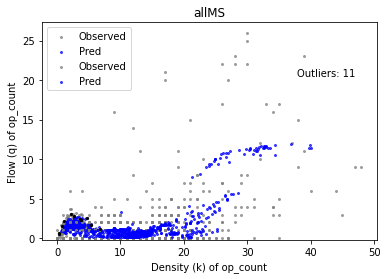

##################################################################
5 Scen0_qk 0.6
##################################################################


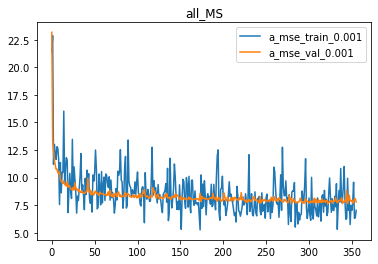

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [245.95299    15.679388    1.3288697   3.9475174]
Loss MAPE
 [0.14320683, 0.1502955, 0.57882845, 0.4542441]
Loss RMSE
 [475.0396    25.591257   2.659934   5.436426]
Loss R2
 [0.737233754816047, 0.8076040930019256, 0.5156377049184859, 0.5159969705158363]
Loss MAE
 [245.95293, 15.679376, 1.3288708, 3.9475195]
Loss MAPE
 [3.4649266e+16, 1027462000000000.0, 1634781200000000.0, 494557530000000.0]
Loss RMSE
 [475.039472044166, 25.59126972108848, 2.659933610245392, 5.436427218841591]
Loss R2
 [0.6968801550944395, 0.8054319841187673, 0.5151516391222168, 0.5141988483099731]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
5 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


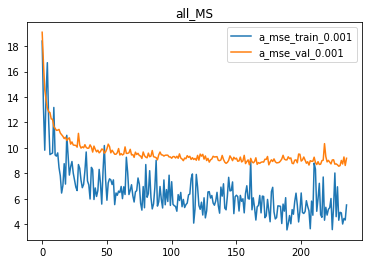

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [217.92259    14.218359    1.0540762   3.9050598]
Loss MAPE
 [0.12802391, 0.1468641, 0.46319535, 0.44162214]
Loss RMSE
 [318.73517    22.278328    1.7695508   5.249684 ]
Loss R2
 [0.866712973335223, 0.863527591075449, 0.7636720675173081, 0.5980891462147511]
Loss MAE
 [217.92256, 14.218366, 1.0540764, 3.9050612]
Loss MAPE
 [3616993600000000.0, 119091760000000.0, 1564163000000000.0, 327739700000000.0]
Loss RMSE
 [318.73518347916973, 22.27832696903119, 1.7695507191645914, 5.249684642221229]
Loss R2
 [0.861385528799415, 0.8618541822792404, 0.7448372871510558, 0.5942714630619597]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
5 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


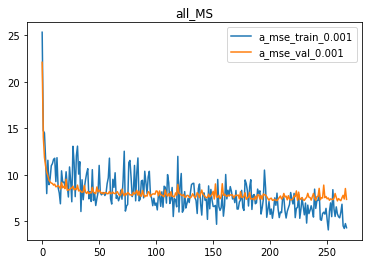

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [221.867      16.507105    1.231869    3.8581026]
Loss MAPE
 [0.1526727, 0.19160646, 0.48605964, 0.43287894]
Loss RMSE
 [353.80365    25.101473    1.9823133   5.0195704]
Loss R2
 [0.8388070575557909, 0.8096342261300093, 0.6975429002219153, 0.600160092067507]
Loss MAE
 [221.86676, 16.507113, 1.2318691, 3.8581028]
Loss MAPE
 [1.830118e+16, 506320740000000.0, 2312597200000000.0, 404206600000000.0]
Loss RMSE
 [353.8036840890722, 25.10147861213807, 1.9823139330411388, 5.019570768326928]
Loss R2
 [0.8311778141335695, 0.8003561442560121, 0.6847951009516084, 0.5979465731050946]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
5 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

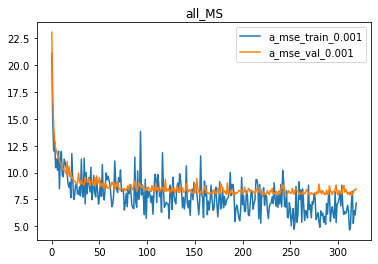

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [205.25601    15.236992    1.2636955   3.8082998]
Loss MAPE
 [0.123444825, 0.17408417, 0.530651, 0.33856946]
Loss RMSE
 [331.3786    24.86871    2.259516   5.213077]
Loss R2
 [0.8604985917671605, 0.8157256543974712, 0.6311604221245294, 0.6177695474159534]
Loss MAE
 [205.25606, 15.236999, 1.2636961, 3.8083003]
Loss MAPE
 [3528145700000000.0, 0.17408417, 1674515100000000.0, 259747840000000.0]
Loss RMSE
 [331.37864247337967, 24.868709209645488, 2.259517144972366, 5.213075762448623]
Loss R2
 [0.8444325334489572, 0.8130612375450003, 0.6293953573216878, 0.5980038714684288]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
5 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

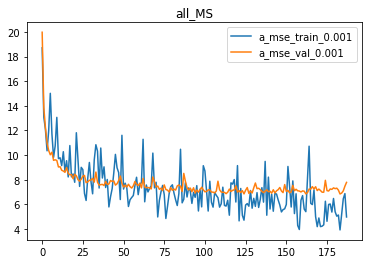

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [209.41586    13.769665    0.9372259   3.722892 ]
Loss MAPE
 [0.17385069, 0.1547331, 0.43789977, 0.4229896]
Loss RMSE
 [328.91687    20.60898     1.5162843   4.9515905]
Loss R2
 [0.8576663779106029, 0.866803917841747, 0.8203045626814525, 0.6314368651284274]
Loss MAE
 [209.4158, 13.769668, 0.9372253, 3.7228923]
Loss MAPE
 [1.4342876e+16, 323604040000000.0, 1425631700000000.0, 499348600000000.0]
Loss RMSE
 [328.91679466469935, 20.608983334744995, 1.5162843666050134, 4.951589641213777]
Loss R2
 [0.8540927292974329, 0.8654231155443988, 0.815579399116718, 0.6087630058602932]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

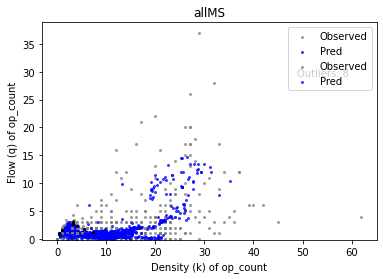

##################################################################
6 Scen0_qk 0.6
##################################################################


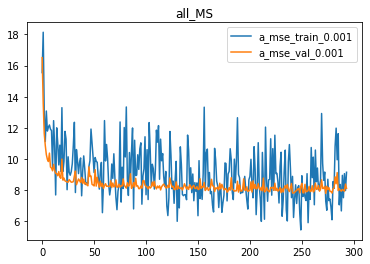

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [274.3785     15.373147    1.2487799   3.955574 ]
Loss MAPE
 [0.17930597, 0.16641626, 0.6201411, 0.4225007]
Loss RMSE
 [408.06488    24.858423    2.1913033   5.2293873]
Loss R2
 [0.8036759718256525, 0.8045227050258467, 0.6162037156089684, 0.5684360784280835]
Loss MAE
 [274.37848, 15.373148, 1.2487798, 3.955574]
Loss MAPE
 [1.6776458e+16, 411840000000000.0, 1734033000000000.0, 512735580000000.0]
Loss RMSE
 [408.0649266660883, 24.858419902299953, 2.1913041959720396, 5.229386323770906]
Loss R2
 [0.7754239725502219, 0.8042037288859726, 0.6148291095848031, 0.5636328039998866]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
6 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

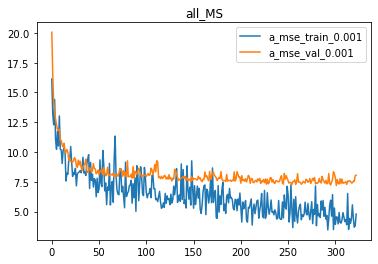

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [222.00545    13.007194    1.0556089   3.735366 ]
Loss MAPE
 [0.1314837, 0.15119338, 0.46679106, 0.3408065]
Loss RMSE
 [327.885      19.410685    1.8591719   5.336735 ]
Loss R2
 [0.8835110843769118, 0.886490531511689, 0.751012611676182, 0.59483920429333]
Loss MAE
 [222.0054, 13.00719, 1.0556093, 3.7353647]
Loss MAPE
 [6456678000000000.0, 0.15119338, 1297009800000000.0, 332996800000000.0]
Loss RMSE
 [327.8849717317035, 19.410683338964315, 1.8591722650356746, 5.336735633596664]
Loss R2
 [0.8476954697448666, 0.8861129068885194, 0.74908951251013, 0.5787060603741685]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
6 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

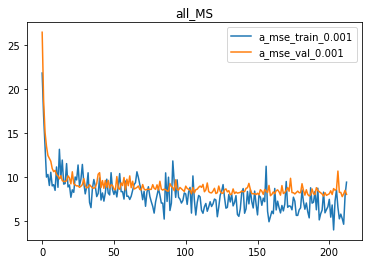

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [250.78062    16.249273    1.127201    3.7809005]
Loss MAPE
 [0.1480032, 0.18192983, 0.5510161, 0.3408097]
Loss RMSE
 [364.05994    26.111435    2.1286988   5.24117  ]
Loss R2
 [0.8289882506658766, 0.8016599072266489, 0.6731873528455569, 0.6029197420504355]
Loss MAE
 [250.78072, 16.24926, 1.1272013, 3.7809012]
Loss MAPE
 [4548916000000000.0, 0.18192983, 1055485300000000.0, 297203600000000.0]
Loss RMSE
 [364.0600053562599, 26.111435576603093, 2.1286992803636458, 5.241170451940943]
Loss R2
 [0.8122345440850404, 0.7939111937659749, 0.6710663923546634, 0.5936592286229152]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
6 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

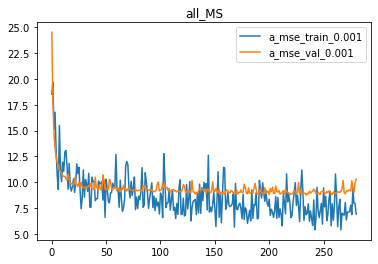

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [260.44717    16.261293    1.4428046   3.870144 ]
Loss MAPE
 [0.17981465, 0.18709983, 0.5710794, 0.4303365]
Loss RMSE
 [394.50793    25.685022    2.3559515   5.2573786]
Loss R2
 [0.815967356743251, 0.7870095011839345, 0.6347665443953426, 0.586094543781714]
Loss MAE
 [260.44708, 16.261295, 1.4428052, 3.8701425]
Loss MAPE
 [1.095786e+16, 441647930000000.0, 2371165000000000.0, 360160700000000.0]
Loss RMSE
 [394.50776291474926, 25.68501689260565, 2.3559519207360373, 5.257378071356545]
Loss R2
 [0.7950705800216155, 0.7805640480826692, 0.577644171874192, 0.5710602901457436]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
6 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

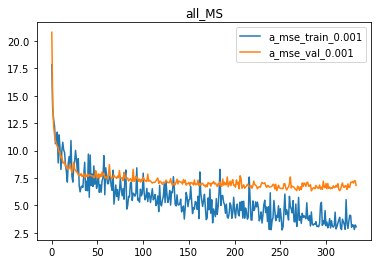

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [243.69249    16.089872    1.0520204   3.7329412]
Loss MAPE
 [0.18434474, 0.19121177, 0.4729595, 0.39403376]
Loss RMSE
 [364.78427    22.759377    1.6108339   5.2628903]
Loss R2
 [0.8355352364248831, 0.8544092169907792, 0.8238174533916343, 0.6175033057593307]
Loss MAE
 [243.69249, 16.08986, 1.0520205, 3.7329414]
Loss MAPE
 [4682834000000000.0, 0.19121177, 1532381500000000.0, 629664700000000.0]
Loss RMSE
 [364.78418277112837, 22.75937467818893, 1.610833553360899, 5.262890567013657]
Loss R2
 [0.8261545771224041, 0.8445218112981379, 0.813068563614054, 0.602844290872418]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

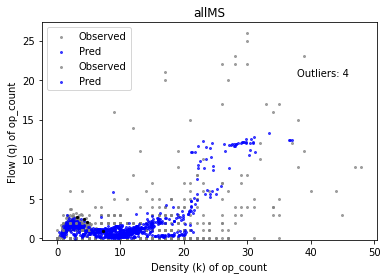

##################################################################
7 Scen0_qk 0.6
##################################################################


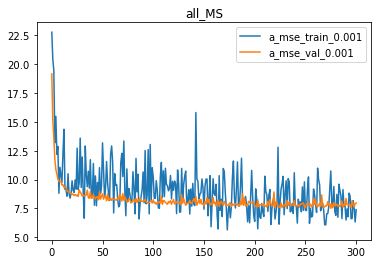

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [229.77179   14.471143   1.154104   4.010589]
Loss MAPE
 [0.1713828, 0.15848611, 0.64452845, 0.44756588]
Loss RMSE
 [383.68976    23.762226    2.178282    5.2631164]
Loss R2
 [0.8162928879462044, 0.8213024708756159, 0.625484585849204, 0.5581754499119101]
Loss MAE
 [229.77164, 14.471141, 1.1541042, 4.0105906]
Loss MAPE
 [1.8724069e+16, 421996170000000.0, 1101772500000000.0, 541398480000000.0]
Loss RMSE
 [383.6897550430556, 23.76222187583818, 2.178281925628997, 5.26311761489312]
Loss R2
 [0.8014521341479748, 0.8210913056110857, 0.6193934539197782, 0.5579852544400342]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
7 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

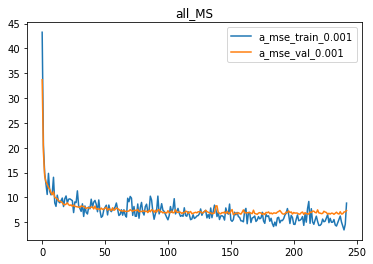

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 17
Loss MAE
 [267.28525    15.504122    1.1575555   3.902722 ]
Loss MAPE
 [0.17196052, 0.14958699, 0.5336463, 0.42924765]
Loss RMSE
 [497.9501     24.58865     2.2208679   5.7083907]
Loss R2
 [0.7256769478306225, 0.8254453852842731, 0.7746330822050002, 0.4868495735614063]
Loss MAE
 [267.28525, 15.504115, 1.1575555, 3.9027221]
Loss MAPE
 [3.2878136e+16, 1069691700000000.0, 1031032200000000.0, 356783370000000.0]
Loss RMSE
 [497.94993787026425, 24.588644542342863, 2.2208679191754306, 5.708390989731729]
Loss R2
 [0.6669370313612871, 0.8203790779556346, 0.6620053684072513, 0.464377466603868]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
7 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


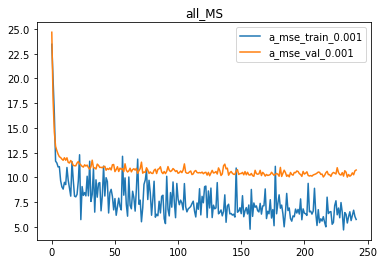

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [231.46628    16.320045    1.2547752   4.0985227]
Loss MAPE
 [0.14427574, 0.16757807, 0.5186138, 0.47525293]
Loss RMSE
 [357.36374    26.42984     1.9185308   5.4876437]
Loss R2
 [0.8484686105148443, 0.8071839927385231, 0.7162320500071737, 0.5827681465749034]
Loss MAE
 [231.46626, 16.32005, 1.2547754, 4.0985236]
Loss MAPE
 [6025694700000000.0, 263612860000000.0, 2194582500000000.0, 344701430000000.0]
Loss RMSE
 [357.363599415917, 26.429832988071336, 1.9185312227159637, 5.487644362234337]
Loss R2
 [0.8257514484056319, 0.8055708392764459, 0.7000637597026018, 0.5566558083255384]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
7 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


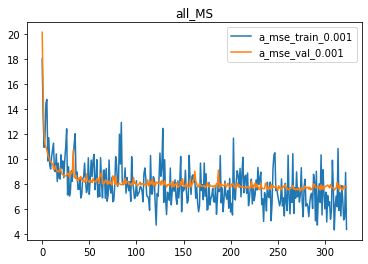

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [224.23953    17.586197    1.222393    4.0502076]
Loss MAPE
 [0.17260724, 0.20081602, 0.61546606, 0.47848734]
Loss RMSE
 [386.57632    28.759539    2.099094    5.4483566]
Loss R2
 [0.8264247959061947, 0.7831716645610882, 0.588554698765721, 0.5596456456069895]
Loss MAE
 [224.23947, 17.586195, 1.2223934, 4.0502057]
Loss MAPE
 [7170606300000000.0, 218238610000000.0, 1751089300000000.0, 114923380000000.0]
Loss RMSE
 [386.57633867711047, 28.75953794742222, 2.099093323209098, 5.448357101735552]
Loss R2
 [0.8087893816132758, 0.773154195593481, 0.5751926959027087, 0.5519083456859536]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
7 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

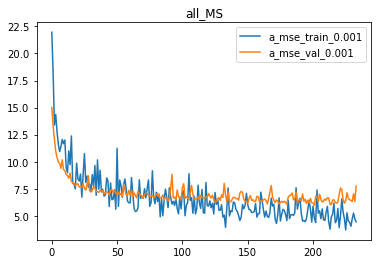

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 24
Loss MAE
 [309.07898   13.498542   1.053804   4.144512]
Loss MAPE
 [0.18888304, 0.1457822, 0.37373695, 0.48230466]
Loss RMSE
 [449.01547    20.745213    1.6127045   5.874227 ]
Loss R2
 [0.8293400791406714, 0.8759527514597959, 0.8590344986536378, 0.6194760014149098]
Loss MAE
 [309.079, 13.498536, 1.0538039, 4.144511]
Loss MAPE
 [1.1868723e+16, 450850130000000.0, 1870235000000000.0, 361712100000000.0]
Loss RMSE
 [449.01558992979295, 20.74521517450997, 1.612704194617208, 5.87422791947183]
Loss R2
 [0.7362696598917633, 0.8730852706893768, 0.8549405590787396, 0.5805523189683266]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


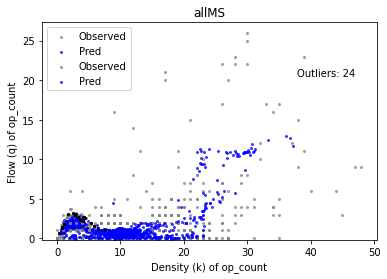

##################################################################
8 Scen0_qk 0.6
##################################################################


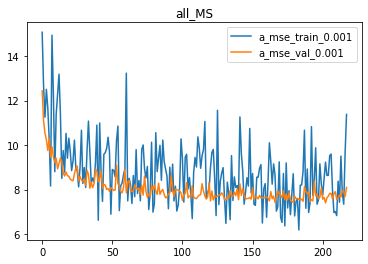

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [282.5264     15.677445    1.5781636   4.0781264]
Loss MAPE
 [0.16419233, 0.16353852, 0.6372161, 0.4526555]
Loss RMSE
 [450.15262    26.44302     2.9247632   5.812746 ]
Loss R2
 [0.7970134203354196, 0.7938043212650298, 0.5381003270180288, 0.5920489157971818]
Loss MAE
 [282.52643, 15.677437, 1.5781629, 4.078127]
Loss MAPE
 [1.5388522e+16, 578780060000000.0, 2460396700000000.0, 368070880000000.0]
Loss RMSE
 [450.1525956550734, 26.443021734240208, 2.9247631140096266, 5.812746104290916]
Loss R2
 [0.7349323235443018, 0.7937954339710878, 0.5228906470338419, 0.5892865809990957]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
8 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


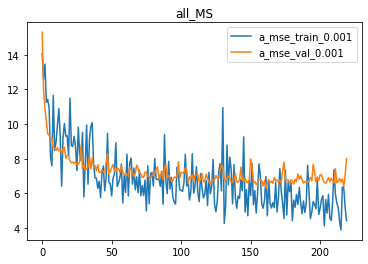

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [248.90073   14.453      1.073247   4.124331]
Loss MAPE
 [0.15377843, 0.15417404, 0.50647044, 0.470828]
Loss RMSE
 [392.599      22.09615     1.8362569   5.804524 ]
Loss R2
 [0.80243724582925, 0.8581829780243068, 0.8120925842850086, 0.6212409124101939]
Loss MAE
 [248.90077, 14.453, 1.0732468, 4.124328]
Loss MAPE
 [1.4775535e+16, 651373100000000.0, 1353831800000000.0, 399620970000000.0]
Loss RMSE
 [392.59903209254094, 22.09614845649187, 1.8362572574147462, 5.804522546655229]
Loss R2
 [0.7983790354401858, 0.8560176363361963, 0.8119368808654069, 0.5904478422662647]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
8 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


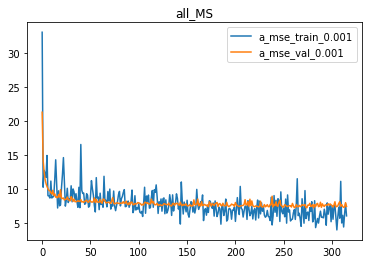

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [229.13374    16.294283    1.0961018   3.847976 ]
Loss MAPE
 [0.15750973, 0.19033252, 0.5341198, 0.43521056]
Loss RMSE
 [371.94534   25.88111    2.038182   4.999173]
Loss R2
 [0.8268751670371599, 0.7895886959183851, 0.6794785267597562, 0.6070896445575781]
Loss MAE
 [229.13362, 16.294273, 1.0961013, 3.8479745]
Loss MAPE
 [1.8939532e+16, 351370030000000.0, 1396469300000000.0, 443308070000000.0]
Loss RMSE
 [371.94530847962045, 25.881107512512266, 2.0381823280692073, 4.999175003654411]
Loss R2
 [0.8134209022648966, 0.7877620255876351, 0.6667776507615437, 0.6012072141147253]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
8 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

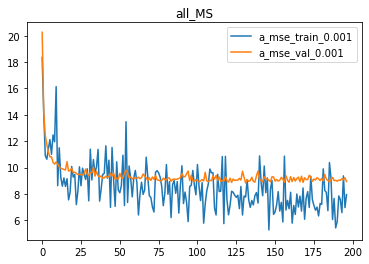

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [232.23584    16.51035     1.1934866   3.6836526]
Loss MAPE
 [0.17202154, 0.17389408, 0.5651709, 0.3864999]
Loss RMSE
 [389.58136    26.395918    2.1646662   5.0574255]
Loss R2
 [0.8135414586479031, 0.7750074115604547, 0.6564577974885359, 0.6056538429897881]
Loss MAE
 [232.23578, 16.51034, 1.1934859, 3.6836505]
Loss MAPE
 [1.1227954e+16, 420202660000000.0, 1187813200000000.0, 344744540000000.0]
Loss RMSE
 [389.5813658595596, 26.395914906107514, 2.164666267203876, 5.057424379199195]
Loss R2
 [0.800156706419276, 0.7682490461572532, 0.6434441794858446, 0.6030674996731366]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
8 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

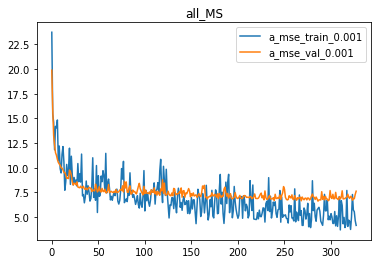

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [231.36583    14.462732    1.0309598   4.0032372]
Loss MAPE
 [0.16792609, 0.1738227, 0.44935358, 0.4041877]
Loss RMSE
 [363.26804    22.326984    1.6552068   5.4072275]
Loss R2
 [0.8430090148112672, 0.8728432919409315, 0.7429446450161795, 0.5832774731461192]
Loss MAE
 [231.36574, 14.462729, 1.03096, 4.0032363]
Loss MAPE
 [1729594100000000.0, 25315496000000.0, 1691003100000000.0, 256044070000000.0]
Loss RMSE
 [363.26800110249184, 22.326989179035788, 1.655206891638014, 5.407227003425799]
Loss R2
 [0.8311520515535105, 0.8632815148934746, 0.735860681089091, 0.5586481689969247]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

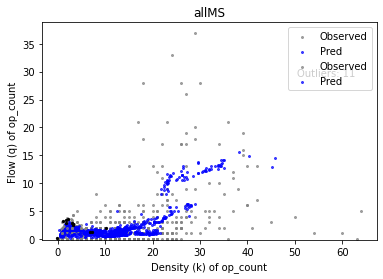

##################################################################
9 Scen0_qk 0.6
##################################################################


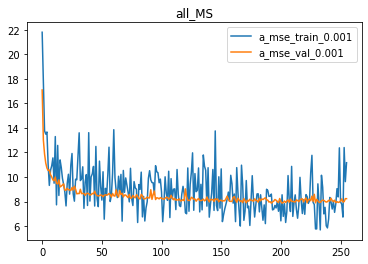

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [226.97812    16.825132    1.1710355   4.070795 ]
Loss MAPE
 [0.16341631, 0.18866646, 0.64086807, 0.43725917]
Loss RMSE
 [389.51324    29.500168    2.1797967   5.3490677]
Loss R2
 [0.8301332113400277, 0.763299980635794, 0.5475108215921779, 0.5743369838554909]
Loss MAE
 [226.97826, 16.825142, 1.1710359, 4.070795]
Loss MAPE
 [7084342400000000.0, 187499400000000.0, 1425154700000000.0, 129011666000000.0]
Loss RMSE
 [389.5130975012265, 29.50016551860345, 2.179796769879544, 5.3490697248004135]
Loss R2
 [0.805873125445273, 0.7613200741235345, 0.5418998127346943, 0.5680910211831488]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
9 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

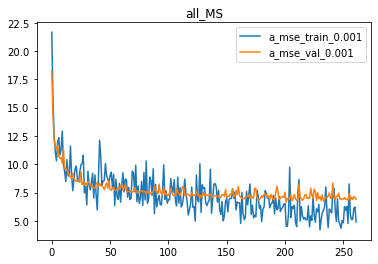

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 17
Loss MAE
 [255.17148    15.660717    1.0979327   3.804771 ]
Loss MAPE
 [0.15477121, 0.15502042, 0.47395262, 0.41974527]
Loss RMSE
 [415.92407    23.302368    1.8869636   5.6096277]
Loss R2
 [0.785751475735935, 0.846809235634779, 0.7578152973657395, 0.5184495932495047]
Loss MAE
 [255.1716, 15.660712, 1.0979323, 3.8047688]
Loss MAPE
 [3.054506e+16, 1069034140000000.0, 1617000600000000.0, 333462440000000.0]
Loss RMSE
 [415.9239714178542, 23.302359085827423, 1.886963064356838, 5.60962882570084]
Loss R2
 [0.7676284813301162, 0.8386802644814053, 0.7559992719114601, 0.48275097093896235]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
9 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


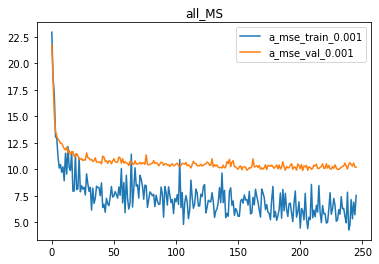

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [237.49524    15.550226    1.1799036   3.8445468]
Loss MAPE
 [0.13739862, 0.15239075, 0.5841869, 0.38428932]
Loss RMSE
 [347.9795     26.744726    1.937708    5.3502645]
Loss R2
 [0.8499359085199901, 0.8014344631907022, 0.7133116753120122, 0.5877195415319822]
Loss MAE
 [237.49515, 15.550229, 1.1799036, 3.844547]
Loss MAPE
 [5163514000000000.0, 316121500000000.0, 1615875400000000.0, 234629330000000.0]
Loss RMSE
 [347.97946913216015, 26.744727640097004, 1.93770801288944, 5.350265546251445]
Loss R2
 [0.8347825820603625, 0.8009102208217349, 0.6940377422655135, 0.5785754800960917]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
9 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


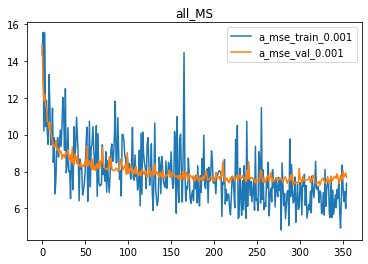

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [255.54024    16.172981    1.3790853   4.0586333]
Loss MAPE
 [0.15513608, 0.15699776, 0.54523927, 0.46755958]
Loss RMSE
 [463.18948    26.086826    2.7095098   5.5604873]
Loss R2
 [0.7575721918705897, 0.8012772764828556, 0.49720266225494814, 0.5220362558847372]
Loss MAE
 [255.54015, 16.172983, 1.3790864, 4.058632]
Loss MAPE
 [3.622329e+16, 1085710350000000.0, 1982155600000000.0, 422984200000000.0]
Loss RMSE
 [463.1893848632544, 26.086825428508927, 2.7095087777344204, 5.560487361652455]
Loss R2
 [0.7118144506722544, 0.7978237136404709, 0.49691024516601834, 0.4917737020067068]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
9 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


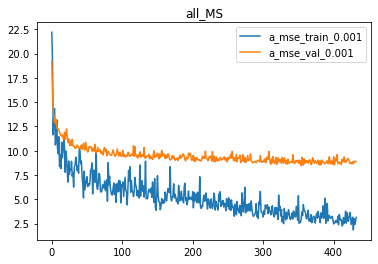

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [188.98653    14.415039    0.9870325   3.847525 ]
Loss MAPE
 [0.1294278, 0.15154374, 0.43995562, 0.40675804]
Loss RMSE
 [289.87363   22.811575   1.583525   5.246397]
Loss R2
 [0.8874400332935892, 0.855359477324121, 0.8254012458024242, 0.6075059667243388]
Loss MAE
 [188.98665, 14.4150505, 0.9870322, 3.847525]
Loss MAPE
 [6643699700000000.0, 197324540000000.0, 1546617000000000.0, 395340970000000.0]
Loss RMSE
 [289.8735715790593, 22.811579604720492, 1.583525152466181, 5.246395872140874]
Loss R2
 [0.8853521897563579, 0.8551617470882885, 0.7956657727296531, 0.5947796974341057]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


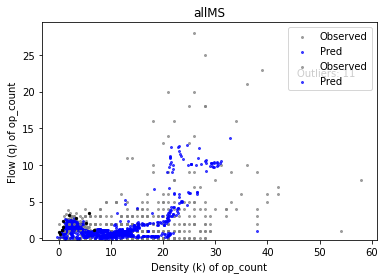

##################################################################
10 Scen0_qk 0.6
##################################################################


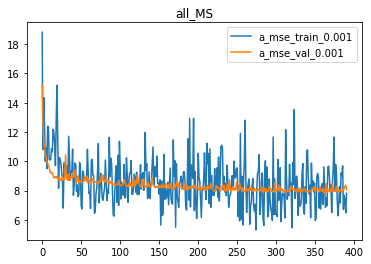

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [238.50708    16.678585    1.3272516   4.029185 ]
Loss MAPE
 [0.16305263, 0.19581051, 0.6443112, 0.47908986]
Loss RMSE
 [415.46527    28.816292    2.27997     5.3184466]
Loss R2
 [0.8326126239168988, 0.7794802481184142, 0.5377038263838575, 0.5793361133875383]
Loss MAE
 [238.50699, 16.678589, 1.3272523, 4.029186]
Loss MAPE
 [6657986400000000.0, 303711260000000.0, 2076485300000000.0, 170694600000000.0]
Loss RMSE
 [415.465270058762, 28.816289491172565, 2.27996999285845, 5.318448674309975]
Loss R2
 [0.7791431072314741, 0.7722580351073616, 0.4988280882762003, 0.5730218719073518]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
10 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

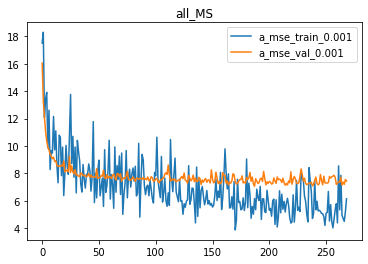

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [195.0876     13.180856    1.0234293   3.7819006]
Loss MAPE
 [0.14006764, 0.14627802, 0.47968942, 0.41378108]
Loss RMSE
 [311.05942    19.978045    1.7628492   4.984889 ]
Loss R2
 [0.8751102718217926, 0.8748007018634365, 0.7541232342423884, 0.6043225062584477]
Loss MAE
 [195.08769, 13.180859, 1.023429, 3.7819004]
Loss MAPE
 [1.4099351e+16, 278513430000000.0, 1386998500000000.0, 475341380000000.0]
Loss RMSE
 [311.0593291479939, 19.978050394335124, 1.7628492293430849, 4.984889084663907]
Loss R2
 [0.8695057847757175, 0.873536972478471, 0.7507251594620725, 0.6034831822228329]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
10 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

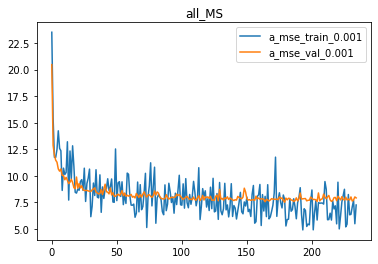

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [250.78107    16.706135    1.2686318   3.927907 ]
Loss MAPE
 [0.14550108, 0.16181979, 0.52059263, 0.45259988]
Loss RMSE
 [427.9638     27.363974    2.5056138   5.3824205]
Loss R2
 [0.7818249505826619, 0.7819125101892981, 0.5711898724646904, 0.5553097369147268]
Loss MAE
 [250.78094, 16.706146, 1.2686316, 3.9279082]
Loss MAPE
 [4.1843526e+16, 1266403600000000.0, 1718949400000000.0, 393404200000000.0]
Loss RMSE
 [427.96374700434615, 27.363981354801744, 2.505613700020997, 5.382420230740369]
Loss R2
 [0.7539808229376246, 0.777542871325131, 0.569778059625985, 0.523803042787581]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
10 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


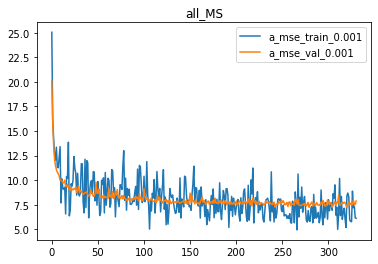

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [272.0517     16.31793     1.3935411   4.0150995]
Loss MAPE
 [0.14648633, 0.15638237, 0.6034571, 0.45462045]
Loss RMSE
 [421.67975    29.965754    2.7151825   5.5052814]
Loss R2
 [0.7818633809044223, 0.7445705611121308, 0.5141098198140721, 0.5350462645097767]
Loss MAE
 [272.05167, 16.317932, 1.3935411, 4.0150976]
Loss MAPE
 [3.767565e+16, 1147541700000000.0, 1874242100000000.0, 418948400000000.0]
Loss RMSE
 [421.67973258742234, 29.965760082863742, 2.7151822764151463, 5.505281859899054]
Loss R2
 [0.7611526636189111, 0.7332291680456746, 0.4948011237337696, 0.5018151791609256]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
10 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


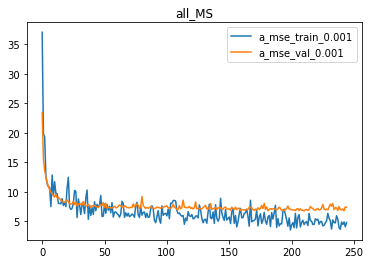

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [261.42505    14.323952    1.1240903   3.9763014]
Loss MAPE
 [0.18427454, 0.18482853, 0.42903313, 0.43483317]
Loss RMSE
 [381.6615     21.459867    1.7037857   5.436231 ]
Loss R2
 [0.8296299215796321, 0.8620211258378621, 0.7964411488963136, 0.6183235134058704]
Loss MAE
 [261.4251, 14.323952, 1.1240901, 3.9763024]
Loss MAPE
 [3826859600000000.0, 0.18482853, 1877209800000000.0, 673926400000000.0]
Loss RMSE
 [381.6615401766335, 21.459865280823497, 1.7037855494730374, 5.436231092401264]
Loss R2
 [0.8096959506761772, 0.8617698440736588, 0.790872621978904, 0.5762516770855843]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

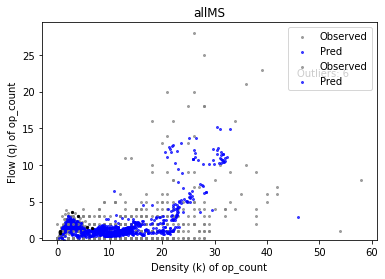

##################################################################
11 Scen0_qk 0.6
##################################################################


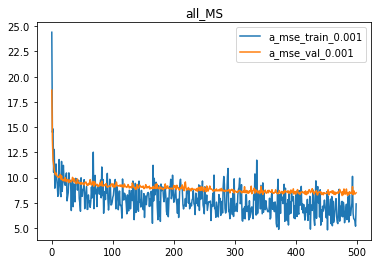

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [208.7796     16.410107    1.2726572   3.860485 ]
Loss MAPE
 [0.18144289, 0.1878071, 0.6051481, 0.40661123]
Loss RMSE
 [362.10962    27.498627    2.2991216   5.3769593]
Loss R2
 [0.8408162824182852, 0.8015172286868198, 0.6154494528068861, 0.5999229452052407]
Loss MAE
 [208.7796, 16.410103, 1.2726566, 3.8604865]
Loss MAPE
 [2.1966282e+16, 625587800000000.0, 1364492000000000.0, 351529750000000.0]
Loss RMSE
 [362.1096821061265, 27.49862279044341, 2.2991211995238743, 5.376958800623593]
Loss R2
 [0.8346583290838807, 0.7760024184030496, 0.605802660742889, 0.5998172112443951]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
11 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


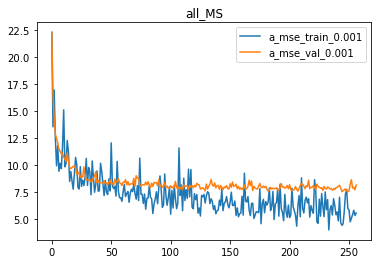

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [237.09558    15.643286    1.0685544   3.8679261]
Loss MAPE
 [0.18926936, 0.1784153, 0.4378495, 0.4557407]
Loss RMSE
 [374.36575    23.848896    1.7312298   5.3276186]
Loss R2
 [0.8577219660420278, 0.8138473286169048, 0.7726646286892453, 0.5806501326287884]
Loss MAE
 [237.09564, 15.643285, 1.0685542, 3.8679247]
Loss MAPE
 [1.0314827e+16, 357012000000000.0, 1509027000000000.0, 432199800000000.0]
Loss RMSE
 [374.36569270567514, 23.848907432882278, 1.7312297998895567, 5.327618258813736]
Loss R2
 [0.8154622267757277, 0.8108157333073921, 0.7719368791731951, 0.5595221685556013]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
11 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

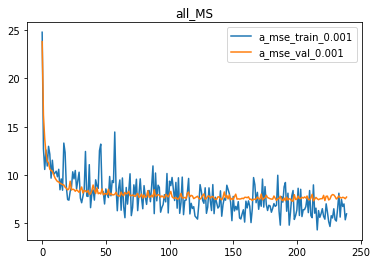

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [283.54938    19.708591    1.2207367   4.0453124]
Loss MAPE
 [0.22078532, 0.2493793, 0.6012166, 0.47660336]
Loss RMSE
 [464.70856    29.342615    2.2195761   5.730177 ]
Loss R2
 [0.7932177544702763, 0.7612509622852318, 0.6517395088122057, 0.5498973632526326]
Loss MAE
 [283.54938, 19.708584, 1.2207367, 4.045312]
Loss MAPE
 [4392945200000000.0, 0.2493793, 1224010200000000.0, 790167950000000.0]
Loss RMSE
 [464.70861165896207, 29.342625735584637, 2.219575862577152, 5.73017550747231]
Loss R2
 [0.7178677730589264, 0.7415677250832167, 0.6450877344764305, 0.5291874996977676]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
11 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

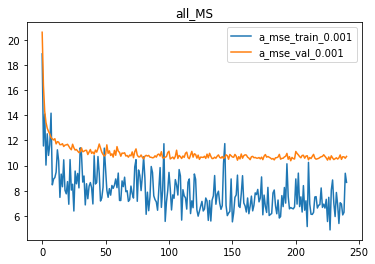

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [218.1508     16.821558    1.173403    4.0616484]
Loss MAPE
 [0.12668887, 0.17104886, 0.6218405, 0.41421756]
Loss RMSE
 [353.88916    27.778511    2.0824502   5.464763 ]
Loss R2
 [0.8427853167775561, 0.7877048230516599, 0.6484504426057355, 0.5706724587128243]
Loss MAE
 [218.1508, 16.82155, 1.1734022, 4.061651]
Loss MAPE
 [6009062400000000.0, 233622950000000.0, 1256073900000000.0, 267964120000000.0]
Loss RMSE
 [353.88919522924124, 27.778512414330702, 2.0824508959784325, 5.464763823463941]
Loss R2
 [0.8291231721094985, 0.7852216144933973, 0.6466209919212256, 0.5603451502178923]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
11 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


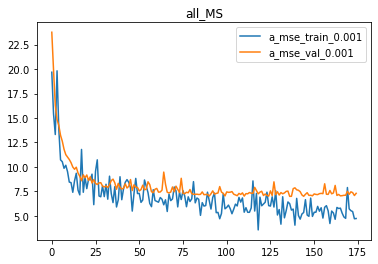

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [226.87312    13.845216    1.0358243   3.8779557]
Loss MAPE
 [0.13365908, 0.15709415, 0.47577894, 0.36729634]
Loss RMSE
 [329.97598    20.134905    1.6911725   5.3181953]
Loss R2
 [0.8705227823118554, 0.8784876528030643, 0.8006493240660394, 0.5983708058276155]
Loss MAE
 [226.87317, 13.845223, 1.0358235, 3.8779583]
Loss MAPE
 [5310446000000000.0, 0.15709415, 1175062000000000.0, 438956230000000.0]
Loss RMSE
 [329.97606447286444, 20.134910275846927, 1.6911723831985914, 5.318195655703975]
Loss R2
 [0.8457466278603147, 0.8774559448665168, 0.7923866080066982, 0.5816281493461304]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

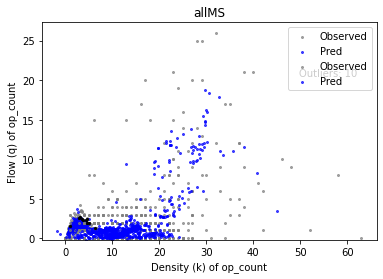

##################################################################
12 Scen0_qk 0.6
##################################################################


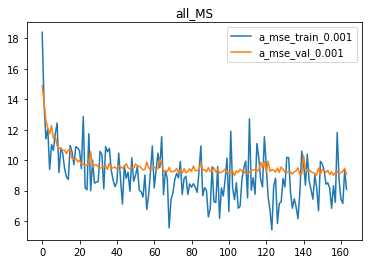

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [219.89267    16.462471    1.3414594   3.7826605]
Loss MAPE
 [0.16754402, 0.18331972, 0.53563684, 0.40332818]
Loss RMSE
 [377.82822    25.507675    2.2453065   5.1876106]
Loss R2
 [0.8254125042930511, 0.7846900505850348, 0.6212587869513263, 0.5846232888006258]
Loss MAE
 [219.89272, 16.462477, 1.3414603, 3.7826605]
Loss MAPE
 [1.3211866e+16, 359624360000000.0, 1996587500000000.0, 317451970000000.0]
Loss RMSE
 [377.82827200330047, 25.50767252067258, 2.245306630083772, 5.187611774021717]
Loss R2
 [0.8120327604726749, 0.7835838251807701, 0.6163837509903352, 0.5823689542551536]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
12 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

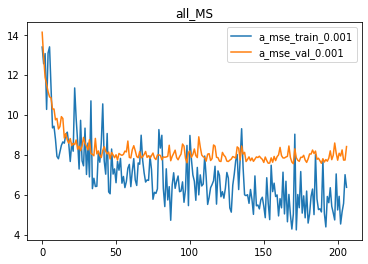

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 13
Loss MAE
 [223.32875    14.592658    1.2518101   4.0206065]
Loss MAPE
 [0.18419482, 0.16638891, 0.42123234, 0.41653576]
Loss RMSE
 [355.88052    21.388037    1.9544346   5.525339 ]
Loss R2
 [0.8423845092138766, 0.8693673524474401, 0.7238248209793671, 0.5824104159801641]
Loss MAE
 [223.3288, 14.592656, 1.2518107, 4.0206084]
Loss MAPE
 [1.8840763e+16, 394079830000000.0, 2088919400000000.0, 482166550000000.0]
Loss RMSE
 [355.88054307239105, 21.388027571252845, 1.954435107481307, 5.5253405711987]
Loss R2
 [0.8402979337885375, 0.8644926213665378, 0.7151393442029965, 0.5774256814100338]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
12 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


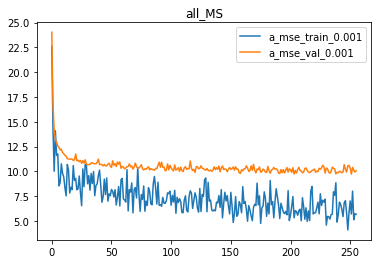

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [225.04842    16.280645    1.1205158   3.922684 ]
Loss MAPE
 [0.1427976, 0.15637188, 0.5676916, 0.42320535]
Loss RMSE
 [362.32623    27.787588    1.9179856   5.2785835]
Loss R2
 [0.8379289757668642, 0.7866337688518519, 0.7052476426208346, 0.5904289135115558]
Loss MAE
 [225.04857, 16.28066, 1.120516, 3.9226835]
Loss MAPE
 [7701208000000000.0, 306126750000000.0, 1300242800000000.0, 258203370000000.0]
Loss RMSE
 [362.3262730261221, 27.787595283870036, 1.917985717946997, 5.27858526956988]
Loss R2
 [0.8208782923080822, 0.7850811240886567, 0.7002343034836009, 0.5897919521239607]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
12 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


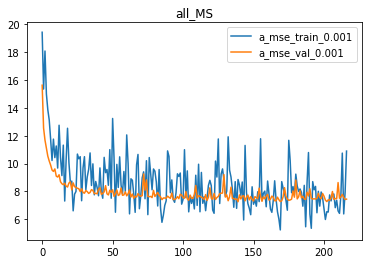

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [234.12141    15.458109    1.1597427   3.9983003]
Loss MAPE
 [0.17260894, 0.17095476, 0.66999316, 0.4170353]
Loss RMSE
 [394.57797    24.971102    2.2323933   5.1954546]
Loss R2
 [0.814227276212365, 0.8049842878486717, 0.6346421866068966, 0.5722068180863853]
Loss MAE
 [234.12132, 15.458104, 1.159743, 3.9982994]
Loss MAPE
 [2.046597e+16, 423617150000000.0, 883561540000000.0, 515499800000000.0]
Loss RMSE
 [394.5778994698005, 24.97110023943616, 2.2323929325073224, 5.195455311124578]
Loss R2
 [0.7900236950387305, 0.8024246892843163, 0.600249173993779, 0.5692772277040239]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
12 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

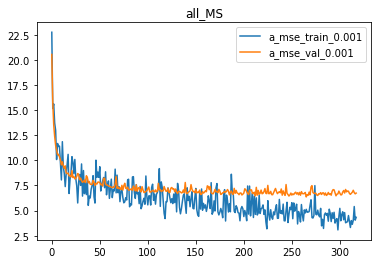

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [224.9291     13.676952    1.0062395   3.957056 ]
Loss MAPE
 [0.16961004, 0.16460364, 0.43456405, 0.4542168]
Loss RMSE
 [348.32394    21.15971     1.5595285   5.1967907]
Loss R2
 [0.8511273792326197, 0.8780190603018512, 0.7787954960441512, 0.5953090775071278]
Loss MAE
 [224.92896, 13.676955, 1.0062389, 3.957057]
Loss MAPE
 [6065762400000000.0, 234509440000000.0, 1739379600000000.0, 278560390000000.0]
Loss RMSE
 [348.32401178715776, 21.15970879684282, 1.5595281185588425, 5.196792001801241]
Loss R2
 [0.844758325067831, 0.8772034060441125, 0.7655150960179615, 0.5923322355878349]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

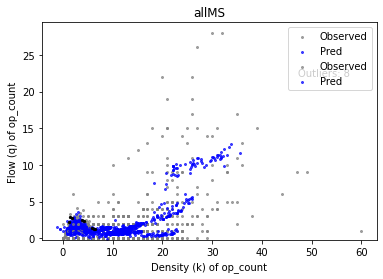

##################################################################
13 Scen0_qk 0.6
##################################################################


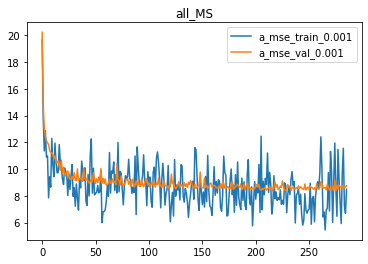

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [218.15872    16.289171    1.2555087   3.8455324]
Loss MAPE
 [0.12779456, 0.19094826, 0.5385027, 0.36354533]
Loss RMSE
 [376.16483   26.122507   2.278385   5.399226]
Loss R2
 [0.8369936148599728, 0.796751034583858, 0.624895296092658, 0.5705879834891917]
Loss MAE
 [218.15897, 16.289173, 1.2555084, 3.8455334]
Loss MAPE
 [5980515400000000.0, 0.19094826, 1614848800000000.0, 420337480000000.0]
Loss RMSE
 [376.1649405513491, 26.12250590853424, 2.2783850878530227, 5.399229397360993]
Loss R2
 [0.7995406000846437, 0.7937364081589571, 0.6231800682564586, 0.5687814836893482]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
13 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

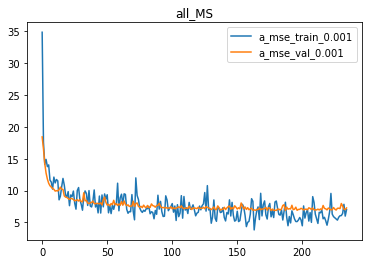

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [212.20274    15.1919985   1.1443785   3.983409 ]
Loss MAPE
 [0.16473775, 0.17585912, 0.5681434, 0.47882542]
Loss RMSE
 [355.6573     24.422186    1.9483507   5.269712 ]
Loss R2
 [0.8479444487731979, 0.8374281493929864, 0.670679165162135, 0.6074549036269485]
Loss MAE
 [212.20268, 15.191998, 1.1443784, 3.9834082]
Loss MAPE
 [5879390400000000.0, 184456030000000.0, 1648019900000000.0, 212542980000000.0]
Loss RMSE
 [355.65723711531587, 24.42218489886552, 1.9483509769516445, 5.269710959048792]
Loss R2
 [0.838152946114112, 0.8364178223372303, 0.6340153552707933, 0.5808115474527598]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
13 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

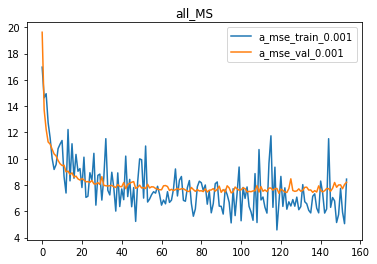

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 18
Loss MAE
 [254.939      17.611462    1.2983813   4.133749 ]
Loss MAPE
 [0.20777436, 0.20678629, 0.52788955, 0.5059435]
Loss RMSE
 [426.69012    27.861488    2.1378293   5.762725 ]
Loss R2
 [0.7959978612540273, 0.7710964567254254, 0.6781432875963497, 0.5541763477176639]
Loss MAE
 [254.93901, 17.611452, 1.2983816, 4.133747]
Loss MAPE
 [2847496200000000.0, 0.20678629, 1969341400000000.0, 838756000000000.0]
Loss RMSE
 [426.69015031401887, 27.861483594137738, 2.1378293681556144, 5.762725680021876]
Loss R2
 [0.7621426810349574, 0.7669992541680172, 0.670748989742806, 0.5238233951982129]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
13 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

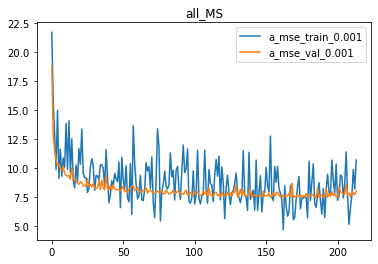

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 2
Loss MAE
 [234.58884    14.972869    1.2026408   3.9926918]
Loss MAPE
 [0.16449612, 0.17144038, 0.6416789, 0.4476059]
Loss RMSE
 [383.11716   23.526577   2.148175   5.229338]
Loss R2
 [0.8283668955990116, 0.8289908727599955, 0.6323946461863406, 0.5743865428486419]
Loss MAE
 [234.5888, 14.972869, 1.202642, 3.9926915]
Loss MAPE
 [1.8151992e+16, 434481880000000.0, 1430291100000000.0, 552126840000000.0]
Loss RMSE
 [383.11710840159566, 23.526579414884004, 2.148175476742003, 5.229336354616788]
Loss R2
 [0.8020443429560605, 0.8246220807052689, 0.6298416221601473, 0.5636411844368696]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
13 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

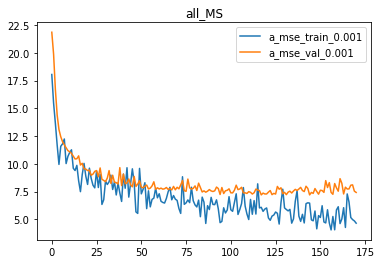

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [233.005      14.446523    1.0398561   3.7034786]
Loss MAPE
 [0.14340049, 0.16416387, 0.45900327, 0.35659948]
Loss RMSE
 [338.15088    22.112299    1.6511881   5.0980377]
Loss R2
 [0.8488260188265866, 0.8564783094984142, 0.8049826381664371, 0.6171567093580188]
Loss MAE
 [233.00485, 14.446526, 1.0398558, 3.703476]
Loss MAPE
 [4213967700000000.0, 0.16416387, 1306327300000000.0, 324380320000000.0]
Loss RMSE
 [338.1508770135012, 22.11230035306813, 1.6511879343732352, 5.098037880829741]
Loss R2
 [0.8380090247148287, 0.8522046547228744, 0.8020877780461781, 0.6155499572410736]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

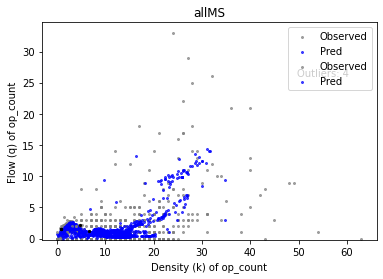

##################################################################
14 Scen0_qk 0.6
##################################################################


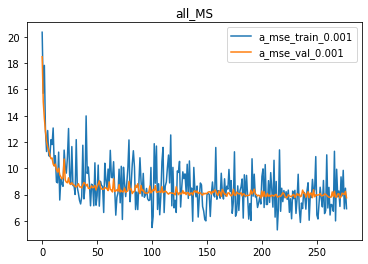

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [244.51607    15.778174    1.3429606   3.925341 ]
Loss MAPE
 [0.14409165, 0.15070784, 0.5952881, 0.43514928]
Loss RMSE
 [468.21225    26.964851    2.6565235   5.3864307]
Loss R2
 [0.7433426766014904, 0.7855047377637749, 0.5166317958915725, 0.5254619495097105]
Loss MAE
 [244.51607, 15.778175, 1.34296, 3.9253402]
Loss MAPE
 [3.8296905e+16, 1111307100000000.0, 1695692700000000.0, 351458750000000.0]
Loss RMSE
 [468.21215810783895, 26.96484459881572, 2.656524644004663, 5.386431226463573]
Loss R2
 [0.7055304473856358, 0.7839851524416317, 0.5163936051228815, 0.5230930711887929]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
14 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


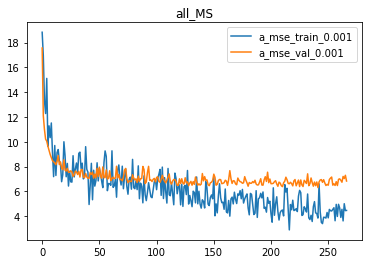

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 20
Loss MAE
 [223.8588    14.656999   1.106061   4.019331]
Loss MAPE
 [0.14207263, 0.15573023, 0.43840706, 0.44702077]
Loss RMSE
 [347.79263    20.999893    1.8314945   5.616747 ]
Loss R2
 [0.8491341392204387, 0.8709157774390061, 0.815406625490639, 0.626938864096724]
Loss MAE
 [223.85884, 14.657008, 1.1060609, 4.01933]
Loss MAPE
 [1.1698146e+16, 442382840000000.0, 1684327300000000.0, 314856130000000.0]
Loss RMSE
 [347.7926151099244, 20.999889555141117, 1.8314946086115818, 5.616746739270471]
Loss R2
 [0.8417739490826639, 0.8699500545096888, 0.8129111838656602, 0.6165171769228859]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
14 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


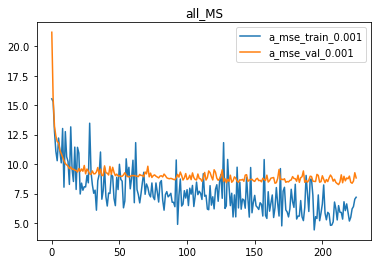

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 3
Loss MAE
 [227.10205    17.008312    1.2698153   3.7832768]
Loss MAPE
 [0.1705461, 0.1950046, 0.5223972, 0.3567687]
Loss RMSE
 [380.21396    24.872753    2.1716464   5.1381216]
Loss R2
 [0.8185497365474865, 0.8046095862052941, 0.6437678616112786, 0.6127117082737982]
Loss MAE
 [227.10208, 17.008303, 1.2698162, 3.7832754]
Loss MAPE
 [1.1685545e+16, 427632550000000.0, 1862351200000000.0, 321214660000000.0]
Loss RMSE
 [380.2140022408433, 24.872767055871066, 2.171646106102499, 5.138120278738062]
Loss R2
 [0.8096515318698961, 0.7942232612807525, 0.6411410947380993, 0.5902995793478043]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
14 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

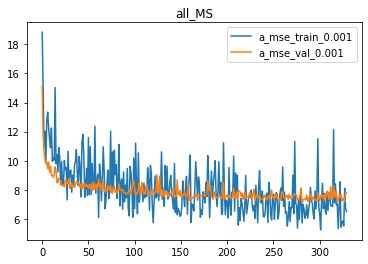

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [240.54607    16.379393    1.39248     3.9734433]
Loss MAPE
 [0.15025452, 0.1738195, 0.6169384, 0.4478628]
Loss RMSE
 [385.60327    26.767912    2.7773693   5.65136  ]
Loss R2
 [0.8116657315636376, 0.7933282987851284, 0.5742487165761236, 0.6187608989399245]
Loss MAE
 [240.54599, 16.379393, 1.39248, 3.9734433]
Loss MAPE
 [1.4546044e+16, 577486900000000.0, 1682114100000000.0, 424540170000000.0]
Loss RMSE
 [385.60320035627296, 26.76790981929202, 2.7773686446778973, 5.651362715594611]
Loss R2
 [0.8055004945953724, 0.7886972920807119, 0.5697671268299591, 0.6117758249829086]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
14 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


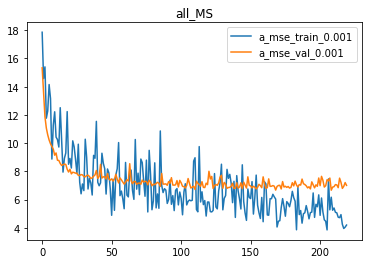

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [224.52182    14.223684    0.9048602   3.695612 ]
Loss MAPE
 [0.15175995, 0.15318015, 0.45699397, 0.41152424]
Loss RMSE
 [348.89865   21.121305   1.54491    4.818208]
Loss R2
 [0.8411701905384662, 0.8609409379364787, 0.8117594048347145, 0.6329509235462912]
Loss MAE
 [224.52182, 14.223685, 0.9048606, 3.6956134]
Loss MAPE
 [1.5441945e+16, 253745860000000.0, 1128869700000000.0, 497392650000000.0]
Loss RMSE
 [348.89871381247593, 21.12130867573743, 1.544910223491343, 4.8182079599106435]
Loss R2
 [0.835826313703206, 0.8586489590401445, 0.8085503512590305, 0.6295567575075574]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

Please set the FD type to 'D', 'T', or 'G'.


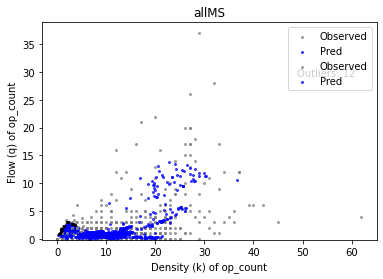

##################################################################
15 Scen0_qk 0.6
##################################################################


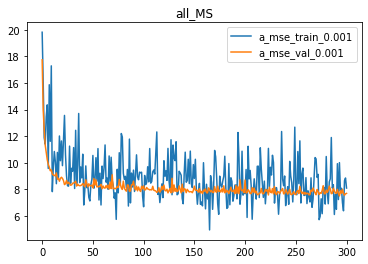

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [235.42514    15.422173    1.1598586   3.8898377]
Loss MAPE
 [0.15839237, 0.1569229, 0.602148, 0.43092206]
Loss RMSE
 [380.6299     25.282703    2.2501965   5.143434 ]
Loss R2
 [0.8146860796843228, 0.8080763131668415, 0.6205791592842981, 0.5786367239961974]
Loss MAE
 [235.42526, 15.422174, 1.1598587, 3.8898363]
Loss MAPE
 [1.6669405e+16, 408916620000000.0, 1171332600000000.0, 512158540000000.0]
Loss RMSE
 [380.6300287024133, 25.282702127254293, 2.2501963423786266, 5.143434632136728]
Loss R2
 [0.8046061487783964, 0.7974630291801514, 0.5938476816091511, 0.577859446142836]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
15 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

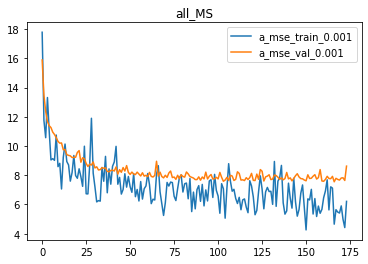

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [247.1185     14.599172    1.3703294   4.2006745]
Loss MAPE
 [0.19807631, 0.17277701, 0.4339091, 0.49558112]
Loss RMSE
 [377.9065     22.546673    2.0630617   5.5744095]
Loss R2
 [0.8279510128274702, 0.8571390700622219, 0.7067504275549433, 0.598909750723941]
Loss MAE
 [247.11836, 14.599164, 1.3703285, 4.200675]
Loss MAPE
 [1.1389501e+16, 495315160000000.0, 2415775800000000.0, 419919100000000.0]
Loss RMSE
 [377.9064451024883, 22.546684153298322, 2.0630619555076826, 5.574409679412321]
Loss R2
 [0.819917850950257, 0.8494132343817076, 0.6825944513483866, 0.5698867955787164]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
15 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


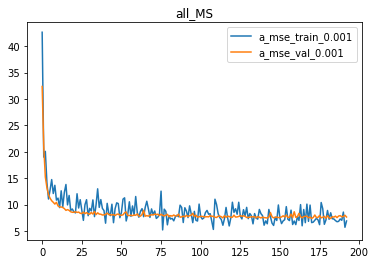

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [255.0379     16.135323    1.3579125   3.8665826]
Loss MAPE
 [0.1700684, 0.1858103, 0.51387775, 0.39843103]
Loss RMSE
 [414.61588    26.303814    2.1773813   5.064874 ]
Loss R2
 [0.7890459509974325, 0.7814789484531265, 0.6399997739043747, 0.5947174762557762]
Loss MAE
 [255.03795, 16.135319, 1.3579129, 3.866581]
Loss MAPE
 [2.000254e+16, 326959420000000.0, 2594457100000000.0, 453912540000000.0]
Loss RMSE
 [414.61582368501087, 26.303818527746593, 2.1773812730483, 5.064874162984233]
Loss R2
 [0.7681556170227462, 0.7807725548192377, 0.6197081422473644, 0.5906564779759211]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
15 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

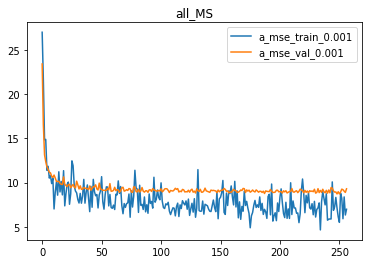

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [250.83818    16.646257    1.2587343   3.970474 ]
Loss MAPE
 [0.19474998, 0.19235644, 0.6034272, 0.39189735]
Loss RMSE
 [398.7928     25.389261    2.2575963   5.492829 ]
Loss R2
 [0.8079360557655831, 0.8195769193697131, 0.6257458450943266, 0.5969182641949403]
Loss MAE
 [250.83826, 16.64626, 1.2587341, 3.970472]
Loss MAPE
 [1.8875207e+16, 504205340000000.0, 1156282800000000.0, 252836890000000.0]
Loss RMSE
 [398.7927876729969, 25.38925957867076, 2.2575961210586564, 5.492828722403169]
Loss R2
 [0.7994620173855302, 0.8090492031381799, 0.619913446645901, 0.5823840165723314]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
15 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


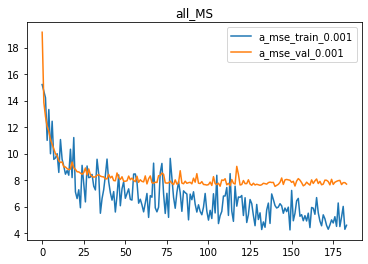

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [213.3058     15.470126    1.0406379   3.94328  ]
Loss MAPE
 [0.19291173, 0.17744926, 0.4900024, 0.41971764]
Loss RMSE
 [359.02673    22.845392    1.638305    5.3875422]
Loss R2
 [0.8388448666158045, 0.8481188629562832, 0.8054681804242175, 0.6047272655798968]
Loss MAE
 [213.30582, 15.470127, 1.040638, 3.9432814]
Loss MAPE
 [1.7988385e+16, 494361940000000.0, 1223338900000000.0, 416354730000000.0]
Loss RMSE
 [359.02659198170824, 22.84539446671569, 1.6383050410226374, 5.38754299350232]
Loss R2
 [0.8374618539005149, 0.8453966946638034, 0.7998389733106595, 0.5982402306437108]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


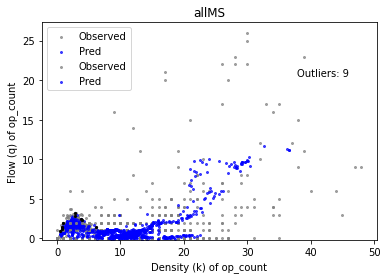

##################################################################
16 Scen0_qk 0.6
##################################################################


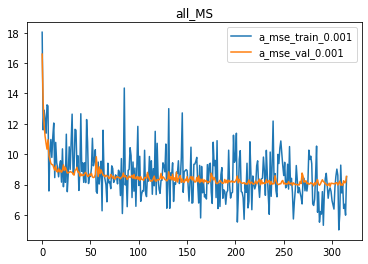

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [226.08176   17.988087   1.203432   4.16868 ]
Loss MAPE
 [0.15913449, 0.18816511, 0.6000053, 0.43669945]
Loss RMSE
 [363.21017    29.213943    2.1841357   5.49789  ]
Loss R2
 [0.8405574755597807, 0.7819110889977254, 0.5422688170555908, 0.5583802591149513]
Loss MAE
 [226.08177, 17.988089, 1.2034316, 4.1686773]
Loss MAPE
 [3573757000000000.0, 53710563000000.0, 1637302700000000.0, 147558430000000.0]
Loss RMSE
 [363.2102524709345, 29.213940947827034, 2.184135247035712, 5.497890588087317]
Loss R2
 [0.8312057303490534, 0.7659291921958791, 0.5400744352882695, 0.5437236646853953]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
16 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

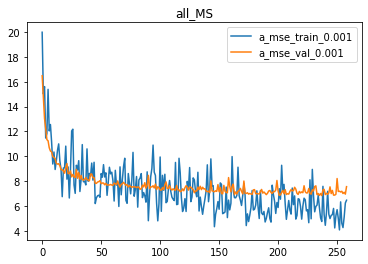

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 12
Loss MAE
 [219.1485    14.344407   1.009471   4.002813]
Loss MAPE
 [0.15979534, 0.18041141, 0.48432136, 0.4111299]
Loss RMSE
 [341.98535    23.297482    1.7519575   5.310086 ]
Loss R2
 [0.862267444671163, 0.8525729011398431, 0.7041399428614665, 0.5954240443469219]
Loss MAE
 [219.1485, 14.344407, 1.0094707, 4.002813]
Loss MAPE
 [3409635200000000.0, 236198760000000.0, 1427118200000000.0, 176202000000000.0]
Loss RMSE
 [341.9853341153682, 23.297491974979167, 1.7519576839187827, 5.3100867680646235]
Loss R2
 [0.8503569737269299, 0.8511375096945415, 0.7040790428334194, 0.5743633928456553]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
16 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

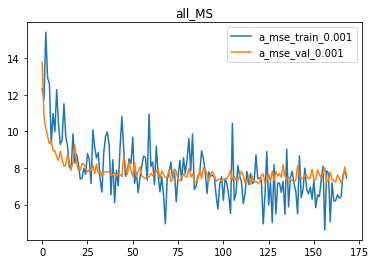

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [243.2707     16.43458     1.3849257   4.0418463]
Loss MAPE
 [0.14872429, 0.17443816, 0.54357463, 0.45697436]
Loss RMSE
 [393.00238   26.711853   2.803069   5.837778]
Loss R2
 [0.8038845148579102, 0.7903582449818234, 0.5847728808399995, 0.5976526379009865]
Loss MAE
 [243.27066, 16.43458, 1.3849257, 4.041848]
Loss MAPE
 [1.4151335e+16, 491777300000000.0, 1807724400000000.0, 434447180000000.0]
Loss RMSE
 [393.00238548894333, 26.711853779253484, 2.803068666094068, 5.837778886100264]
Loss R2
 [0.7979645340260089, 0.7895813588019079, 0.5617680667084873, 0.5857414826975966]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
16 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


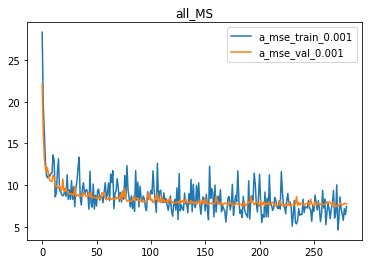

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [265.5913     16.25608     1.3608519   4.016165 ]
Loss MAPE
 [0.15385106, 0.15391044, 0.609341, 0.4448245]
Loss RMSE
 [430.68677    26.928356    2.6343167   5.446486 ]
Loss R2
 [0.7644930055222795, 0.7864809121945867, 0.5311954056810425, 0.5285088745181101]
Loss MAE
 [265.5913, 16.25608, 1.3608515, 4.0161614]
Loss MAPE
 [3.528671e+16, 1211550400000000.0, 1823922200000000.0, 400716420000000.0]
Loss RMSE
 [430.6867698803853, 26.928357053006756, 2.634316939939321, 5.446484739206041]
Loss R2
 [0.7508401637762272, 0.7845693711124518, 0.5244453635309896, 0.5123996854361588]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
16 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


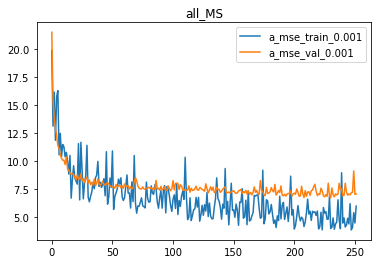

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [238.37553    15.502226    1.0134966   3.8010027]
Loss MAPE
 [0.1846988, 0.1806752, 0.48003107, 0.42240655]
Loss RMSE
 [363.23663    23.225758    1.6224327   5.239646 ]
Loss R2
 [0.834415069261085, 0.8402485076702214, 0.8108236513109836, 0.6196647497484372]
Loss MAE
 [238.37563, 15.502222, 1.0134963, 3.8010035]
Loss MAPE
 [3687190200000000.0, 0.1806752, 1236849100000000.0, 649920600000000.0]
Loss RMSE
 [363.23655773476327, 23.225754432209786, 1.6224325144270992, 5.239645419754647]
Loss R2
 [0.8276265522951481, 0.8380844667491614, 0.8103668400962629, 0.606344816452348]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

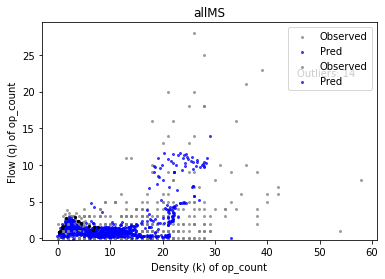

##################################################################
17 Scen0_qk 0.6
##################################################################


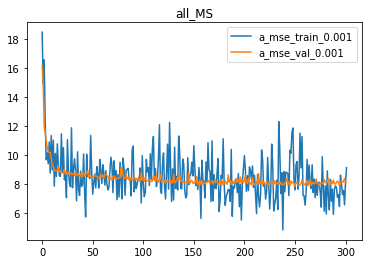

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [224.68149    16.589378    1.2458336   4.031428 ]
Loss MAPE
 [0.15235904, 0.1859961, 0.66517556, 0.439342]
Loss RMSE
 [384.52316    28.621826    2.2509212   5.291929 ]
Loss R2
 [0.821916992571922, 0.776787868401779, 0.5434272959325981, 0.5815297814664208]
Loss MAE
 [224.68153, 16.589378, 1.2458329, 4.0314302]
Loss MAPE
 [4328353000000000.0, 23609238000000.0, 1675541400000000.0, 72943090000000.0]
Loss RMSE
 [384.5232437707765, 28.621828128373565, 2.250921484548506, 5.291929744078219]
Loss R2
 [0.8108150024090703, 0.7753214205380555, 0.511517298350192, 0.5772692434481383]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
17 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

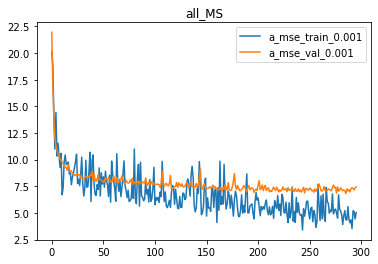

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 11
Loss MAE
 [243.43793    14.998981    1.1253438   3.9486954]
Loss MAPE
 [0.18445948, 0.18133268, 0.5051629, 0.40891027]
Loss RMSE
 [382.03903    21.825548    1.9751074   5.4889016]
Loss R2
 [0.8466483339102701, 0.8579246371698056, 0.7204802057003143, 0.5914945999110359]
Loss MAE
 [243.43808, 14.99899, 1.1253437, 3.948695]
Loss MAPE
 [3368127800000000.0, 0.18133268, 1457045900000000.0, 622708850000000.0]
Loss RMSE
 [382.03897870505307, 21.82554118565849, 1.9751076149895719, 5.488901905519716]
Loss R2
 [0.8093193405500587, 0.8570188183584826, 0.7189636072721189, 0.568000663749411]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
17 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

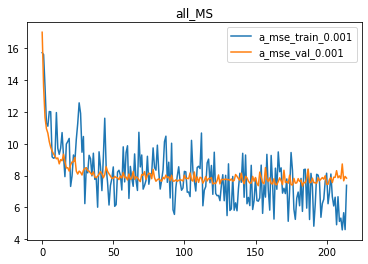

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [261.38928    15.876816    1.127297    3.8959148]
Loss MAPE
 [0.17938448, 0.1733314, 0.54469925, 0.40088376]
Loss RMSE
 [408.97116   25.794764   2.243465   5.126989]
Loss R2
 [0.8097453521983601, 0.792283907493352, 0.6700872663615571, 0.5935077569441187]
Loss MAE
 [261.38928, 15.876817, 1.127297, 3.8959162]
Loss MAPE
 [1.6247223e+16, 360598100000000.0, 1180058200000000.0, 354872700000000.0]
Loss RMSE
 [408.9713658986409, 25.794762084124027, 2.24346515260672, 5.126987537086894]
Loss R2
 [0.7744251695900581, 0.7891758203270616, 0.5962739731142197, 0.5805548987684478]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
17 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

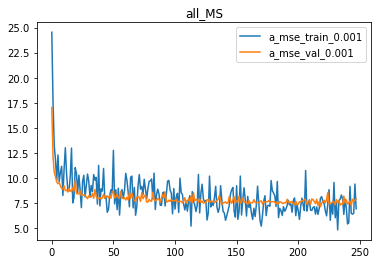

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 7
Loss MAE
 [256.04688    16.340788    1.4182234   4.002824 ]
Loss MAPE
 [0.15028349, 0.16971408, 0.61068946, 0.42021403]
Loss RMSE
 [409.62366    26.313467    2.7774072   5.687869 ]
Loss R2
 [0.8110568841236412, 0.7958278876580861, 0.5727522124951095, 0.6078735515750425]
Loss MAE
 [256.04684, 16.340786, 1.4182227, 4.002821]
Loss MAPE
 [1.5476486e+16, 592036750000000.0, 1901683900000000.0, 367260240000000.0]
Loss RMSE
 [409.6236840076511, 26.313464946677016, 2.777406329645051, 5.687869552511443]
Loss R2
 [0.7805137236669409, 0.7958110582314685, 0.5697554421213198, 0.606743894257995]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
17 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


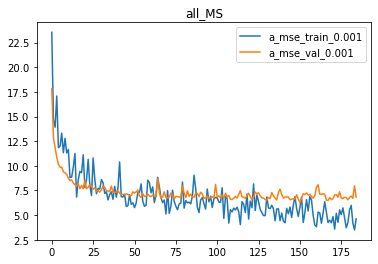

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 15
Loss MAE
 [236.82568    14.652025    1.0500493   3.8737595]
Loss MAPE
 [0.14960074, 0.1641471, 0.38491336, 0.42205796]
Loss RMSE
 [365.50504   22.2033     1.652916   5.500202]
Loss R2
 [0.8338374971419974, 0.8594659449414139, 0.8604039305103557, 0.6398011538527075]
Loss MAE
 [236.82576, 14.652032, 1.0500491, 3.873759]
Loss MAPE
 [1.3260815e+16, 586395200000000.0, 1784513700000000.0, 307373460000000.0]
Loss RMSE
 [365.50506579936757, 22.203295433898997, 1.6529159817583212, 5.5002030421839]
Loss R2
 [0.8252472158467481, 0.8546178785930589, 0.847616448579654, 0.6322660982968509]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


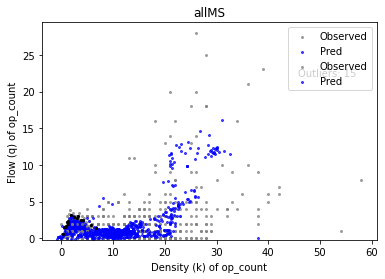

##################################################################
18 Scen0_qk 0.6
##################################################################


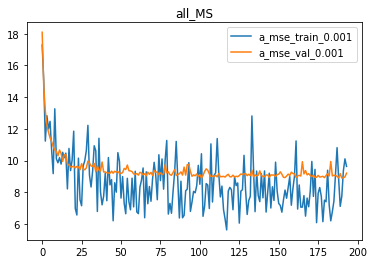

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 13
Loss MAE
 [235.41396    16.782043    1.391966    4.1479673]
Loss MAPE
 [0.19587824, 0.20104054, 0.609626, 0.4105025]
Loss RMSE
 [409.84344    27.458263    2.3469293   5.659982 ]
Loss R2
 [0.8026707581439002, 0.7886502887063845, 0.6044968567126497, 0.5641314689298567]
Loss MAE
 [235.41386, 16.78204, 1.3919669, 4.14797]
Loss MAPE
 [2.1698317e+16, 537474800000000.0, 1855460400000000.0, 309304250000000.0]
Loss RMSE
 [409.8434724074546, 27.458272452472656, 2.3469284884558235, 5.659982366635518]
Loss R2
 [0.7881940841792803, 0.7766593297814466, 0.5892385598581706, 0.5565801583765284]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
18 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


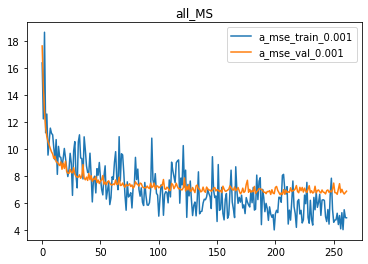

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 9
Loss MAE
 [199.58961    14.628469    1.1283425   3.8514562]
Loss MAPE
 [0.160115, 0.1635934, 0.4584015, 0.43140092]
Loss RMSE
 [339.48816    23.761148    1.8169597   5.1263905]
Loss R2
 [0.8568697649158368, 0.8484210236178827, 0.6982735481256056, 0.612396867879586]
Loss MAE
 [199.58958, 14.628475, 1.128343, 3.8514574]
Loss MAPE
 [2087135500000000.0, 78641770000000.0, 1965251400000000.0, 214721640000000.0]
Loss RMSE
 [339.48817173798557, 23.761143047953574, 1.8169598791913217, 5.12639096620409]
Loss R2
 [0.8525343765524314, 0.8451534225090144, 0.681712807881697, 0.6033027801761395]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
18 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

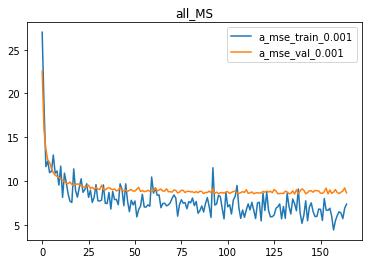

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [237.46486    16.830202    1.3310654   3.9338343]
Loss MAPE
 [0.19246395, 0.19707778, 0.5225695, 0.4017955]
Loss RMSE
 [404.14246    26.09262     2.1199398   5.520358 ]
Loss R2
 [0.7988862682953297, 0.8062491390648315, 0.6924966919308451, 0.5790717166979175]
Loss MAE
 [237.46472, 16.830206, 1.3310652, 3.9338355]
Loss MAPE
 [1.9765485e+16, 532469200000000.0, 2125905300000000.0, 333892370000000.0]
Loss RMSE
 [404.14235966426486, 26.092621373421238, 2.1199398379516396, 5.520357085025515]
Loss R2
 [0.7940457310779069, 0.7983227625691806, 0.664851682357467, 0.5781876242859949]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
18 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


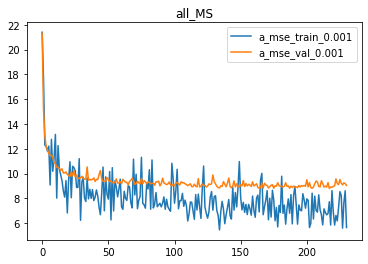

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 4
Loss MAE
 [253.05164    16.845106    1.2815098   4.0054116]
Loss MAPE
 [0.20453478, 0.19135523, 0.636081, 0.41423327]
Loss RMSE
 [403.4665    26.011116   2.253897   5.482135]
Loss R2
 [0.8115174838740444, 0.8044937658561557, 0.626456798692657, 0.5855257004639455]
Loss MAE
 [253.05173, 16.84511, 1.2815084, 4.005412]
Loss MAPE
 [2.2056873e+16, 563143360000000.0, 1140711600000000.0, 273869680000000.0]
Loss RMSE
 [403.46646390995124, 26.011121278710405, 2.253896835545492, 5.482133804107902]
Loss R2
 [0.7947340432261141, 0.799580672146091, 0.6211580574789679, 0.5840086613217006]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
18 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


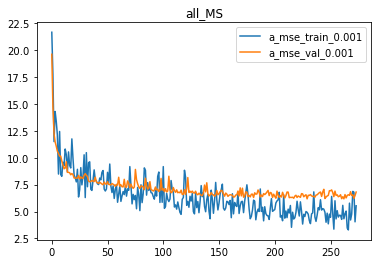

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 14
Loss MAE
 [229.43411    14.265212    1.1399685   3.9502687]
Loss MAPE
 [0.17879643, 0.16498753, 0.4207302, 0.47242028]
Loss RMSE
 [370.17438    21.798994    1.6676966   5.2411613]
Loss R2
 [0.8531629761534474, 0.8710669360158451, 0.7692014387384422, 0.6234291358262245]
Loss MAE
 [229.43423, 14.265219, 1.1399684, 3.9502656]
Loss MAPE
 [6950844000000000.0, 301014760000000.0, 2277975800000000.0, 276337020000000.0]
Loss RMSE
 [370.17447322174985, 21.798987632833004, 1.66769678547483, 5.241162081853767]
Loss R2
 [0.8246707243561338, 0.8696714423287051, 0.7318593457037572, 0.5853411964744939]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

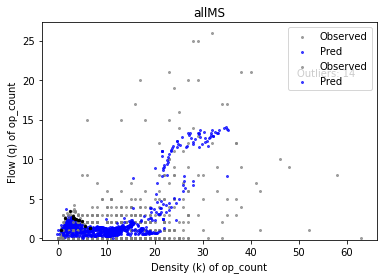

##################################################################
19 Scen0_qk 0.6
##################################################################


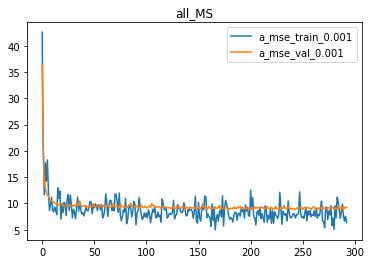

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 10
Loss MAE
 [228.3582     16.676458    1.2115426   3.6970892]
Loss MAPE
 [0.17655861, 0.18587948, 0.58708125, 0.3952643]
Loss RMSE
 [401.73016   27.000935   2.17158    5.130032]
Loss R2
 [0.8350079510667857, 0.7639306848637296, 0.6427740101872054, 0.5919931584966021]
Loss MAE
 [228.35812, 16.676462, 1.211542, 3.6970906]
Loss MAPE
 [1.3164415e+16, 482993670000000.0, 1223127200000000.0, 399258280000000.0]
Loss RMSE
 [401.730125519608, 27.000933595693734, 2.1715800133038865, 5.1300305124308645]
Loss R2
 [0.7874984869318196, 0.7575034271086873, 0.6411629166306122, 0.5915886801331567]

Input
['q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
19 Scen1_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

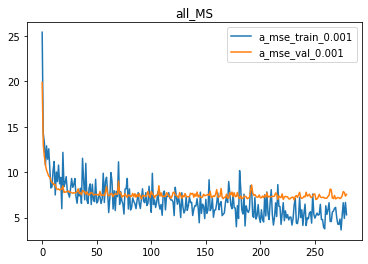

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 6
Loss MAE
 [207.37373   13.773619   1.026184   3.776485]
Loss MAPE
 [0.15349644, 0.16054153, 0.4877528, 0.43548512]
Loss RMSE
 [335.33548    19.903063    1.8579645   4.950765 ]
Loss R2
 [0.8512635610985211, 0.8747541357119558, 0.7490572910643086, 0.6192672551204347]
Loss MAE
 [207.37369, 13.773611, 1.0261832, 3.7764826]
Loss MAPE
 [1.4758431e+16, 382436800000000.0, 1172149300000000.0, 607368500000000.0]
Loss RMSE
 [335.335454712889, 19.903059435733585, 1.8579636033499933, 4.950764668289258]
Loss R2
 [0.8483425501881104, 0.8744845987133613, 0.7231002818652759, 0.6088933716637933]

Input
['q_Taxi_MS', 'k_Taxi_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
19 Scen3_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

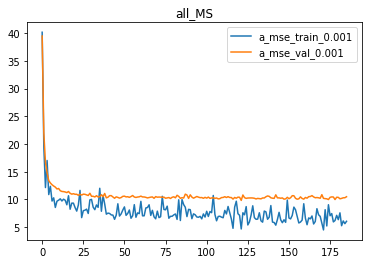

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 15
Loss MAE
 [257.3777     16.152243    1.1595538   3.8795419]
Loss MAPE
 [0.15869151, 0.1647436, 0.5517214, 0.40544823]
Loss RMSE
 [404.58832    26.401503    1.9072502   5.4439015]
Loss R2
 [0.8329462384352961, 0.8065802626094071, 0.7063121163055783, 0.5703424661268459]
Loss MAE
 [257.37784, 16.15224, 1.159554, 3.8795424]
Loss MAPE
 [7213051000000000.0, 296554740000000.0, 1641553000000000.0, 257021930000000.0]
Loss RMSE
 [404.58839037347576, 26.401513536011294, 1.9072498763496017, 5.443900889989127]
Loss R2
 [0.7766554109879183, 0.8059872632071196, 0.7035807710622095, 0.5636957031253866]

Input
['q_Bus_MS', 'k_Bus_MS', 'q_all_LD', 'k_all_LD', 'q_Car0050_MS', 'k_Car0050_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
19 Scen10_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


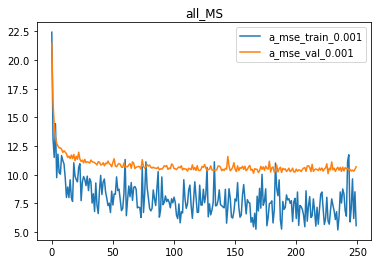

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 8
Loss MAE
 [275.51367    15.552774    1.2756131   3.973069 ]
Loss MAPE
 [0.16188626, 0.16091269, 0.58908534, 0.40818048]
Loss RMSE
 [383.05078    25.467693    2.0736878   5.356424 ]
Loss R2
 [0.8307023462765455, 0.8204582512945691, 0.6629285523048909, 0.5836751841829124]
Loss MAE
 [275.51385, 15.552771, 1.2756131, 3.9730718]
Loss MAPE
 [8665467500000000.0, 247185450000000.0, 1926061300000000.0, 292624070000000.0]
Loss RMSE
 [383.0507880816851, 25.46769433203257, 2.0736881015546422, 5.356424214435432]
Loss R2
 [0.799801290487065, 0.8194689653023053, 0.6495887540783228, 0.577604752292138]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
##################################################################
19 Scen11_qk 0.6
##################################################################


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: invalid value encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]


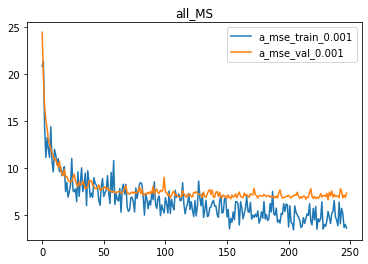

Output
 all_MS
FD factor: 0.6 - Num. outside of FD: 5
Loss MAE
 [216.59131    12.978168    1.103737    3.9106083]
Loss MAPE
 [0.12762243, 0.13979125, 0.46675694, 0.37839225]
Loss RMSE
 [318.7407     20.572052    1.7396094   5.2087107]
Loss R2
 [0.8615523950467151, 0.8741034243699431, 0.8005803202629417, 0.6308421570607349]
Loss MAE
 [216.59126, 12.978165, 1.1037371, 3.910608]
Loss MAPE
 [5477649000000000.0, 0.13979125, 1637744700000000.0, 480935700000000.0]
Loss RMSE
 [318.7405635858103, 20.572045983025955, 1.7396093202884655, 5.208710476254123]
Loss R2
 [0.8560722876607381, 0.8720772273923929, 0.7803237677514421, 0.5986768365156021]

Input
['q_Car0050_MS', 'k_Car0050_MS', 'q_all_LD', 'k_all_LD', 'q_Bus_MS', 'k_Bus_MS', 'q_Taxi_MS', 'k_Taxi_MS']
Output
['q_all_MS', 'k_all_MS', 'stop_count', 'lane_changes']
Please set the FD type to 'D', 'T', or 'G'.


C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: divide by zero encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:186: RuntimeWarning: invalid value encountered in true_divide
  vTarget = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\OneDrive - TUM-VT\Dokumente\TSE_Bottleneck_TRB2022\TRB\src\NNet.py:560: RuntimeWarning: invalid value encountered in true_divide
  avg_mape = [np.nanmean((abs((p[t[:,i]>1,i]-t[t[:,i]>1,i])/t[t[:,i]>1,i]))) for i in range(t.shape[1]) ]
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: divide by zero encountered in true_divide
  vTarget_woinf = t[:,qcols]/t[:,kcols]
C:\Users\ga59com\AppData\Local\Temp\ipykernel_21620\3964681916.py:192: RuntimeWarning: in

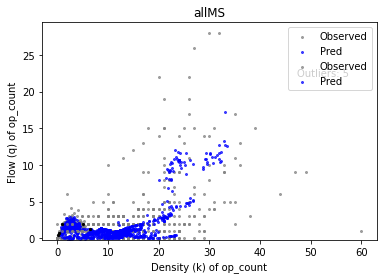

Scenario                   Method  \
0   Scen0_qk  NNFD_w_events_one_stage   
1   Scen1_qk  NNFD_w_events_one_stage   
2   Scen3_qk  NNFD_w_events_one_stage   
3  Scen10_qk  NNFD_w_events_one_stage   
4  Scen11_qk  NNFD_w_events_one_stage   

                                      Params    Pol  Run  \
0  [D_Extended, 1.9, 1.9, 1.6, -0.4, 0, 0.6]  total    0   
1  [D_Extended, 1.9, 1.9, 1.6, -0.4, 0, 0.6]  total    0   
2  [D_Extended, 1.9, 1.9, 1.6, -0.4, 0, 0.6]  total    0   
3  [D_Extended, 1.9, 1.9, 1.6, -0.4, 0, 0.6]  total    0   
4  [D_Extended, 1.9, 1.9, 1.6, -0.4, 0, 0.6]  total    0   

                                                 MAE  \
0  [224.4569549560547, 16.615673065185547, 1.4222...   
1  [215.7767333984375, 13.842570304870605, 1.0481...   
2  [214.05323791503906, 15.64699935913086, 1.1954...   
3  [248.76222229003906, 17.061002731323242, 1.264...   
4  [230.40281677246094, 14.16149616241455, 0.9415...   

                                                MAPE  \
0  [0.180936, 0.2008187, 0.5825882, 0.44077176, 0...   
1  [0.15364699, 0.16114731, 0.47195745, 0.4403192...   
2  [0.13494547, 0.15819392, 0.5198384, 0.42262948...   
3  [0.19829403, 0.20453683, 0.611848, 0.4062258, ...   
4  [0.2040063, 0.16916718, 0.4280051, 0.453969, 0...   

                                                RMSE  \
0  [401.8941345214844, 28.773061752319336, 2.3997...   
1  [331.4615478515625, 21.183210372924805, 1.7361...   
2  [330.5022277832031, 25.282827377319336, 1.8485...   
3  [407.69146728515625, 27.006664276123047, 2.250...   
4  [366.93524169921875, 20.538066864013672, 1.465...   

                                                  R2  \
0  [0.8064934199399385, 0.7544723496612444, 0.601...   
1  [0.8649074104829119, 0.8769927538073203, 0.717...   
2  [0.8557427071441388, 0.8220833425210624, 0.734...   
3  [0.7972418822959702, 0.798004604120323, 0.6254...   
4  [0.8433779577349849, 0.8654949097622124, 0.835...   

                                               MAE_n  \
0  [224.45695, 16.615683, 1.422236, 4.1025386, 3....   
1  [215.77682, 13.842559, 1.0481248, 3.9133816, 2...   
2  [214.05328, 15.646999, 1.1954964, 3.9748397, 3...   
3  [248.76224, 17.060995, 1.2642062, 3.9920194, 3...   
4  [230.4027, 14.1615, 0.9415111, 3.8143988, 3.22...   

                                              MAPE_n  \
0  [5507544000000000.0, 0.2008187, 20715361000000...   
1  [6618483400000000.0, 217203060000000.0, 162200...   
2  [7358197000000000.0, 342525700000000.0, 198572...   
3  [1.8424385e+16, 565198800000000.0, 12224776000...   
4  [0.2040063, 0.16916718, 1407443500000000.0, 52...   

                                                R2_n  Outliers  \
0  [0.7889844515074282, 0.7515031731090903, 0.585...         4   
1  [0.859425052615266, 0.87693038992801, 0.709407...         6   
2  [0.8509619323292351, 0.8220803639766413, 0.721...         6   
3  [0.7904124274684134, 0.783945409468003, 0.6224...         7   
4  [0.8247721785100827, 0.8641524560002444, 0.831...        12   

                                                Cols  
0  [q_all_MS, k_all_MS, stop_count, lane_changes,...  
1  [q_all_MS, k_all_MS, stop_count, lane_changes,...  
2  [q_all_MS, k_all_MS, stop_count, lane_changes,...  
3  [q_all_MS, k_all_MS, stop_count, lane_changes,...  
4  [q_all_MS, k_all_MS, stop_count, lane_changes,...

In [26]:
##############
# NN Params - torch - q&k as multi-output to get FD diagram
##############

# save polygon information
polygoncol = pd.DataFrame(data['polygon'])
polygoncol['idcs'] = polygoncol.index
fixed_cols = ['lanes','busstops','seplane','length','road_rank']
method = 'NNFD_w_events_one_stage'

save_results = 'on'
numruns = 20 # 20
calcV = 'yes'

save_all = []
numoutside = []
runs = []
for run in range(numruns):
    for ii,ff in enumerate([0.6]): #[0,0.3,0.6]
        ff = round(ff,2)
        saveall = []
        allpreds = []
        alltrues = []

        for sensor_scenario in ['Scen%s_qk'%i for i in [0,1,3,10,11]]:#[1,2,3,4,5,6,7,8,9,10]]:

            print('##################################################################')
            print(run,sensor_scenario,ff)
            print('##################################################################')
        
            input_sensor_cols,output_sensor_cols = sensor_scenarios[sensor_scenario]
            output_sensor_cols = ['q_all_MS','k_all_MS','stop_count','lane_changes']
            data_norm = data

            ##############
            # 0. split data set
            ##############
            x = np.array(data_norm[fixed_cols+input_sensor_cols])
            y = np.array(data_norm[output_sensor_cols])
            s_train,s_test,s_val,randstate = [0.7,0.15,0.15,randrange(10)]
            x_train, x_test_, y_train, y_test_ = train_test_split(x, y, test_size=s_test, random_state=randstate)
            x_train_, x_val_, y_train_, y_val_ = train_test_split(x_train, y_train, test_size=s_val/(1-s_test), random_state=randstate) # 0.2143 = 0.15 / 0.7
            i_train, i_test, p_train, p_test = train_test_split(polygoncol['idcs'],polygoncol['polygon'],test_size=s_test,random_state=randstate)
            i_train, i_val, p_train, p_val = train_test_split(i_train, p_train,test_size=s_val/(1-s_test),random_state=randstate)

            targetk = output_sensor_cols[1]
            tk = output_sensor_cols.index(targetk)
            targetq = output_sensor_cols[0]
            tq = output_sensor_cols.index(targetq)
            target = targetk[2:]

            ##############
            # 1. Set-up
            ##############
            hparams = {
                "batch_size": 256,
                "learning_rate": 0.001,
                "input_size": len(fixed_cols+input_sensor_cols),
                "output_size": 4,
                "hidden_layers": 7,
                "neurons": 64,
                "inclKaiming": 1,
                "activation_function": torch.nn.LeakyReLU(),
                "gt0_loss_contraint": 0.01, # 0.01, if include loss for values <0 (q, k)
                "underFD_loss_contraint": ff,
                "max_epochs": 500,
                "FDparams":['D_Extended',1.9,1.9,1.6,-0.4,0], #FDType,mid,mid2,slopeL,slopeR,qdist // D_Extended
                #"FDparams":['G',3.9,3.9,1.8,-2.1,0], 
                #"FDparams":['T',1.6,3.5,1.6,-0.5,0], 
                # Daganzo (D), Trapezoid (T), Greenshield (G)
                # FDType, mid, mid2, slopeL, slopeR, qdist
            }
            losses = []
            #loss function for evaluating model output (validation)
            def loss_function(y_predicted, y_target):
                return ((y_predicted - y_target)**2).mean()

            ##############
            # 2. create DataLoader objects
            ##############
            #adjust here
            train_dl = myDataLoader(x_train_,y_train_)
            val_dl = myDataLoader(x_val_,y_val_)
            test_dl = myDataLoader(x_test_,y_test_)   
            train_dl_batches = torch.utils.data.DataLoader(train_dl, batch_size=hparams['batch_size'], shuffle=True)
            
            ##############
            # 3. train model
            ##############
            device = torch.device("cpu")                       
            model = Net(hparams).to(device)
            optimizer = model.configure_optimizer()
            valbreak = 0
            for epoch in range(0, hparams['max_epochs']):
                epoch_loss = 0  # for one full epoch
                if valbreak == 0:
                    
                    for (batch_idx, batch) in enumerate(train_dl_batches):
                        (x_train, y_train) = batch              # (predictors, targets)
                        optimizer.zero_grad()                   # prepare gradients
                        out = model(x_train)                    # predicted
                        # additional loss if above FD curve
                        loss = loss_function_NNFD(y_train,out,hparams['underFD_loss_contraint'],hparams['FDparams']) #ax=0  
                        # additional loss if <0
                        if len(out[out<0])>0:
                            loss_constraint = abs(out[out<0]-y_train[out<0]).sum()
                            loss += loss_constraint*hparams['gt0_loss_contraint']
                        epoch_loss += loss.item()
                        loss.backward(retain_graph=True)        # compute gradients
                        optimizer.step()                        # update
                    
                    (x_val, y_val) = val_dl.getall()
                    with torch.no_grad():
                        loss_val = loss_function(model(x_val), y_val)
                    losses.append([epoch,loss.item(),loss_val.item()])
                    if len(losses)>100:
                        if np.mean(np.array(losses)[-50:,2])>np.mean(np.array(losses)[-100:-50,2]):
                            valbreak = 1
                                                             
            ##############
            # 4. evaluate model accuracy
            ##############
            plot_losses(losses[:],hparams['learning_rate'],target)
            #print('\nInput\n',input_sensor_cols)
            print('Output\n',target)
            # (predictors, targets)
            (x_test, y_test) = test_dl.getall() 
            with torch.no_grad():
                preds = model(x_test)
            # reformat 
            preds_q = preds.detach().numpy()[:,0]
            preds_k = preds.detach().numpy()[:,1]
            preds_stop = preds.detach().numpy()[:,2]
            preds_lanec = preds.detach().numpy()[:,3]
            y_test_q = y_test.detach().numpy()[:,0]
            y_test_k = y_test.detach().numpy()[:,1]
            y_test_stop = y_test.detach().numpy()[:,2]
            y_test_lanec = y_test.detach().numpy()[:,3]
            # save for tmp analysis
            allpreds.append(preds_q); allpreds.append(preds_k); allpreds.append(preds_stop); allpreds.append(preds_lanec)
            alltrues.append(torch.tensor(y_test_q)), alltrues.append(torch.tensor(y_test_k)), 
            alltrues.append(torch.tensor(y_test_stop)), alltrues.append(torch.tensor(y_test_lanec))

            # saving the outliers by FDType
            ax=0
            FDType,mid,mid2,slopeL,slopeR,qdist = hparams['FDparams']
            ALIdcsO,AMIdcsO,ARIdcsO,PLIdcsO,PMIdcsO,PRIdcsO = [[],[],[],[],[],[]]
            if FDType=='D_Extended':
                ALIdcsO = list(np.where((y_test_k<mid) & (qdist+slopeL*y_test_k <= y_test_q))[ax])
                PLIdcsO = list(np.where((preds_k <mid) & (qdist+slopeL*preds_k  <= preds_q ))[ax])
                ARIdcsO = list(np.where((y_test_k>=mid) & ((qdist+slopeL*mid+(y_test_k-mid)*slopeR) <= y_test_q))[ax])
                PRIdcsO = list(np.where((preds_k >=mid) & ((qdist+slopeL*mid+(preds_k -mid)*slopeR) <= preds_q ))[ax])
            elif FDType=='T_Extended':
                ALIdcsO = list(np.where((y_test_k<mid) & (qdist+slopeL*y_test_k <= y_test_q))[ax])
                PLIdcsO = list(np.where((preds_k <mid) & (qdist+slopeL*preds_k  <= preds_q ))[ax])
                AMIdcsO = list(np.where((y_test_k>=mid) & (y_test_k<mid2) & ((qdist+slopeL*mid) <= y_test_q))[ax])
                PMIdcsO = list(np.where((preds_k >=mid) & (preds_k <mid2) & ((qdist+slopeL*mid) <= preds_q ))[ax])
                ARIdcsO = list(np.where((y_test_k>=mid2) & ((qdist+slopeL*mid+(y_test_k-mid2)*slopeR) <= y_test_q))[ax])
                PRIdcsO = list(np.where((preds_k >=mid2) & ((qdist+slopeL*mid+(preds_k -mid2)*slopeR) <= preds_q ))[ax])
            elif FDType=='G_Extended':
                vfree = slopeL
                kjam = mid - slopeL*mid/slopeR # x intercept of slope R
                ALIdcsO = list(np.where((qdist+vfree*y_test_k*(1-(y_test_k/kjam)) <= y_test_q))[ax])
                PLIdcsO = list(np.where((qdist+vfree*preds_k *(1-(preds_k /kjam)) <= preds_q ))[ax])
            else:
                print("Please set the FD type to 'D', 'T', or 'G' '_Extended'.")
            AIdcsO = ALIdcsO+AMIdcsO+ARIdcsO 
            PIdcsO = PLIdcsO+PMIdcsO+PRIdcsO 
            idcs = test_dl.getIdcs()
            idcs = np.array(i_test)[idcs]         
            origO_t = data.loc[ idcs[AIdcsO] ,:]
            origO_p = data.loc[ idcs[PIdcsO] ,:]
            print('FD factor:',hparams['underFD_loss_contraint'],'- Num. outside of FD:',len(PIdcsO))
            
            # overall error
            cols = [a for a in output_sensor_cols]
            p,t = [preds.detach().numpy(),y_test.detach().numpy()]
            p = scaleup_with_events(p,p_test,scalefactors,cols,scale_stop_lc)
            t = scaleup_with_events(t,p_test,scalefactors,cols,scale_stop_lc)
            avg_mae,avg_mape,avg_rmse,r2 = calc_error_values(p,t)
            avg_mae_n,avg_mape_n,avg_rmse_n,r2_n = calc_error_values_default(p,t, verbose='on')
            if calcV=='yes':
                vCols = ['v_%s'%a for a in set([c[2:] for c in output_sensor_cols[:2]])]
                vOrig = np.array(data.iloc[i_test][vCols].values) # 703 x 5
                qcols,kcols = [range(0,len(output_sensor_cols),2),range(1,len(output_sensor_cols),2)]
                vTarget = t[:,qcols]/t[:,kcols]
                vPred   = p[:,qcols]/p[:,kcols]
                vpo_mae,vpo_mape,vpo_rmse,vpo_r2 = calc_error_values(vPred,vOrig,verbose='off')
                vpt_mae,vpt_mape,vpt_rmse,vpt_r2 = calc_error_values(vPred,vTarget,verbose='off')
                mask_vt = (vTarget>3000)
                mask_vp = (vPred>3000)
                vTarget_woinf = t[:,qcols]/t[:,kcols]
                vTarget_woinf[vTarget_woinf>5000] = 5000
                vPred_woinf   = p[:,qcols]/p[:,kcols]
                vPred_woinf[vPred_woinf>5000] = 5000
                vpo_mae_n,vpo_mape_n,vpo_rmse_n,vpo_r2_n = calc_error_values_default(vPred_woinf,vOrig,verbose='off')
                vpt_mae_n,vpt_mape_n,vpt_rmse_n,vpt_r2_n = calc_error_values_default(vPred_woinf,vTarget_woinf,verbose='off')
                avg_mae += vpo_mae + vpt_mae
                avg_mape+= vpo_mape + vpt_mape
                avg_rmse+= vpo_rmse + vpt_rmse
                r2      += vpo_r2 + vpt_r2
                avg_mae_n += vpo_mae_n + vpt_mae_n
                avg_mape_n+= vpo_mape_n + vpt_mape_n
                avg_rmse_n+= vpo_rmse_n + vpt_rmse_n
                r2_n      += vpo_r2_n + vpt_r2_n
                cols    += ['%s_Target'%i for i in vCols] + ['%s_Orig'%i for i in vCols] #wrong way aroung, first is original, then target
            print('\nInput\n%s\nOutput\n%s'%(input_sensor_cols,output_sensor_cols))
            save_all.append([sensor_scenario,method,\
                             hparams['FDparams']+[hparams['underFD_loss_contraint']],\
                             'total',run,avg_mae,avg_mape,avg_rmse,r2,avg_mae_n,avg_mape_n,r2_n,len(PIdcsO),cols])
            numoutside.append([ff,sensor_scenario,len(PIdcsO),avg_rmse[1],avg_mae[1],avg_rmse[0],avg_mae[0]])
            runs.append([run,sensor_scenario,ff,len(PIdcsO)])
            
            # err for each polygon
            #p_copy = p_test.reset_index(inplace=False,drop=True)
            #for pol in set(polygoncol.polygon):
            #    mask = p_copy[p_copy==pol].index.values
            #    avg_mae,avg_mape,avg_rmse,r2 = calc_error_values(p[mask],t[mask],verbose='off')
            #    if calcV=='yes':
            #        vOrig = np.array(data.iloc[i_test][vCols].values)[mask,:] # 703 x 5
            #        vTarget = t[:,qcols][mask,:]/t[:,kcols][mask,:]
            #        vPred   = p[:,qcols][mask,:]/p[:,kcols][mask,:]
            #        vpo_mae,vpo_mape,vpo_rmse,vpo_r2 = calc_error_values(vPred,vOrig,verbose='off')
            #        vTarget_wo_inf = t[:,qcols][mask,:]/t[:,kcols][mask,:]
            #        vPred_wo_inf   = p[:,qcols][mask,:]/p[:,kcols][mask,:]
            #        vpt_mae,vpt_mape,vpt_rmse,vpt_r2 = calc_error_values(vPred,vTarget,verbose='off')
            #        avg_mae += vpo_mae + vpt_mae
            #        avg_mape+= vpo_mape + vpt_mape
            #        avg_rmse+= vpo_rmse + vpt_rmse
            #        r2      += vpo_r2 + vpt_r2
            #    save_all.append([sensor_scenario,method,\
            #                 hparams['FDparams']+[hparams['underFD_loss_contraint']],\
            #                 pol,run,avg_mae,avg_mape,avg_rmse,'-','-','-',r2,len(PIdcsO),cols])

        # plot preds with FD curve
        plot_preds(alltrues,allpreds,avg_mae,avg_rmse,output_sensor_cols,hparams['FDparams'],ff,1,save='off')
        plt.scatter(preds_k[PIdcsO],preds_q[PIdcsO],color='black',s=5)
        plt.ylim(bottom=-0.2)
        plt.text(.75*plt.gca().get_xlim()[1], .75*plt.gca().get_ylim()[1], 'Outliers: %s'%(len(PIdcsO)),size=10)
        plt.title('allMS')
        #plt.savefig('%s_%s.pdf'%(run,ff), format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()
        
results = pd.DataFrame(save_all,columns=['Scenario','Method','Params','Pol','Run','MAE','MAPE','RMSE','R2','MAE_n','MAPE_n','R2_n','Outliers','Cols'])
display(results[results.Pol=='total'].head())
if save_results == 'on':
    results.to_pickle('../output/result_runs_w_events/%s_%s_runs.pkl'%(method,numruns))
    #results.to_csv('../output/results_runs/%s.csv'%(method),index=False)

In [12]:
#print loss of the train dataset:
scale_stop_lc = [[0,1],[0,1]]
with torch.no_grad():
    preds = model(torch.Tensor(np.array(pd.DataFrame(x).iloc[i_test])))
y_p,t_p = [np.array(preds),np.array(pd.DataFrame(y).iloc[i_test])]
y_p = scaleup_with_events(y_p,p_test,scalefactors,output_sensor_cols,scale_stop_lc)
t_p = scaleup_with_events(t_p,p_test,scalefactors,output_sensor_cols,scale_stop_lc)
for i in range(0,4):
    print('R2: %s'%r2_score(t_p[:,i],y_p[:,i]))
    print('MAPE: %s'%mean_absolute_percentage_error(t_p[:,i],y_p[:,i]))
    print('MAE: %s'%mean_absolute_error(t_p[:,i],y_p[:,i]))
    print('RMSE: %s'%mean_squared_error(t_p[:,i],y_p[:,i])**0.5)

R2: 0.8464385823891056
MAPE: 0.17885452822249165
MAE: 212.26039619949574
RMSE: 343.5016620443652
R2: 0.8393555437485654
MAPE: 0.1881688801063773
MAE: 15.328784496423111
RMSE: 22.334004870027197
R2: 0.716187433169262
MAPE: 886332423584812.1
MAE: 0.9779188309310594
RMSE: 1.9002587724262023
R2: 0.576886325385936
MAPE: 445587211226214.56
MAE: 3.866152121682792
RMSE: 5.332312678291095


In [36]:
with torch.no_grad():
    preds = model(torch.Tensor(np.array(pd.DataFrame(x).iloc[i_test])))
y_p,t_p = [np.array(preds),np.array(pd.DataFrame(y).iloc[i_test])]
y_p = scaleup_with_events(y_p,p_test,scalefactors,output_sensor_cols,scale_stop_lc)
t_p = scaleup_with_events(t_p,p_test,scalefactors,output_sensor_cols,scale_stop_lc)
loss = [mean_absolute_error(t_p[:,i],y_p[:,i]) for i in range(0,4)]
acc = [(1 - (loss[i] / t_p[:,i].mean() ))*100 for i in range(0,4)]

In [24]:
vTarget[vTarget>20] = 5000

In [25]:
vTarget

array([[5.000000e+03, 4.000000e-01],
       [5.000000e+03, 1.000000e+00],
       [5.000000e+03, 0.000000e+00],
       ...,
       [6.013687e+00, 0.000000e+00],
       [7.524736e+00,          nan],
       [5.000000e+03, 6.250000e-02]], dtype=float32)